# Desarrollo de algoritmos metaheuristicos para optimizacion de redes neuronales artificiales aplicados a la eficiencia energética bajo Spark

In [1]:
# importar librerías útiles para el proyecto
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import glob
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1 Monto el dataset desde google drive

In [0]:
#carga del dataset Github/Drive/Directamente de Kaggle/Desde local
#GITHUB

#!sudo rm -rfv rmdir /content/tfm

dataset_source="https://github.com/training4future/Hourly_Energy_Consumption.git"

curr_dir = os.getcwd()
if not os.path.exists('/content/tfm/dataset/'):
  !git clone https://github.com/training4future/Hourly_Energy_Consumption.git tfm
  os.chdir('/content/tfm/dataset/')

#google drive
#from google.colab import drive
#drive.mount('/content/gdrive')
#ruta_dataset="/content/gdrive/My Drive/TFM/dataset/hourly-energy-consumption"
#! ls gdrive/My\ Drive/TFM/dataset/hourly-energy-consumption/
#%cd gdrive/My\ Drive/TFM/dataset/hourly-energy-consumption/

In [6]:
dataset_path=os.path.join(curr_dir, 'hourly-energy-consumption')

datasets_path=[]
dataframes={}
for filename in os.listdir(dataset_path):
  if filename.endswith("csv"):
    path=dataset_path+ "/" +filename
    source=filename.split(".")[0]
    datasets_path.append(path)
    dataframes[source] = pd.read_csv(path)

datasets_path

['/content/tfm/dataset/hourly-energy-consumption/FE_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/PJME_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/DUQ_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/DOM_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/pjm_hourly_est.csv',
 '/content/tfm/dataset/hourly-energy-consumption/NI_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/COMED_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/AEP_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/DAYTON_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/DEOK_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/EKPC_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/PJM_Load_hourly.csv',
 '/content/tfm/dataset/hourly-energy-consumption/PJMW_hourly.csv']

In [0]:
print(dataframes.keys())

dict_keys(['FE_hourly', 'PJME_hourly', 'DUQ_hourly', 'DOM_hourly', 'pjm_hourly_est', 'NI_hourly', 'COMED_hourly', 'AEP_hourly', 'DAYTON_hourly', 'DEOK_hourly', 'EKPC_hourly', 'PJM_Load_hourly', 'PJMW_hourly'])


### 2 Análisis EDA del dataset

In [0]:
#Utilizo el dataset que tiene la información de todas las regiones e imprimo las primeras líneas
df=dataframes['pjm_hourly_est']
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [0]:
#imprimo las últimas lineas
df.tail()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
178257,2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
178258,2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
178259,2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
178260,2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN
178261,2018-01-02 00:00:00,19993.0,12816.0,2552.0,4100.0,17428.0,1721.0,2846.0,8393.0,NaN,38608.0,7691.0,NaN


In [0]:
#Tipo de cada feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       121273 non-null  float64
 2   COMED     66497 non-null   float64
 3   DAYTON    121275 non-null  float64
 4   DEOK      57739 non-null   float64
 5   DOM       116189 non-null  float64
 6   DUQ       119068 non-null  float64
 7   EKPC      45334 non-null   float64
 8   FE        62874 non-null   float64
 9   NI        58450 non-null   float64
 10  PJME      145366 non-null  float64
 11  PJMW      143206 non-null  float64
 12  PJM_Load  32896 non-null   float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


In [0]:
#Principales estadísticos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [0]:
print("Mayor energía AEP:",df[df['AEP']==df['AEP'].max()]['Datetime'])
print("Menor energía AEP:",df[df['AEP']==df['AEP'].min()]['Datetime'],"\n")
print("Mayor energía AEP:",df[df['AEP']==df['AEP'].max()]['Datetime'])
print("Menor energía AEP:",df[df['AEP']==df['AEP'].min()]['Datetime'],"\n")
print("Mayor energía COMED:",df[df['COMED']==df['COMED'].max()]['Datetime'])
print("Menor energía COMED:",df[df['COMED']==df['COMED'].min()]['Datetime'],"\n")
print("Mayor energía DAYTON:",df[df['DAYTON']==df['DAYTON'].max()]['Datetime'])
print("Menor energía DAYTON:",df[df['DAYTON']==df['DAYTON'].min()]['Datetime'],"\n")
print("Mayor energía DEOK:",df[df['DEOK']==df['DEOK'].max()]['Datetime'])
print("Menor energía DEOK:",df[df['DEOK']==df['DEOK'].min()]['Datetime'],"\n")
print("Mayor energía DOM:",df[df['DOM']==df['DOM'].max()]['Datetime'])
print("Menor energía DOM:",df[df['DOM']==df['DOM'].min()]['Datetime'],"\n")
print("Mayor energía DUQ:",df[df['DUQ']==df['DUQ'].max()]['Datetime'])
print("Menor energía DUQ:",df[df['DUQ']==df['DUQ'].min()]['Datetime'],"\n")
print("Mayor energía EKPC:",df[df['EKPC']==df['EKPC'].max()]['Datetime'])
print("Menor energía EKPC:",df[df['EKPC']==df['EKPC'].min()]['Datetime'],"\n")
print("Mayor energía FE:",df[df['FE']==df['FE'].max()]['Datetime'])
print("Menor energía FE:",df[df['FE']==df['FE'].min()]['Datetime'],"\n")
print("Mayor energía NI:",df[df['NI']==df['NI'].max()]['Datetime'])
print("Menor energía NI:",df[df['NI']==df['NI'].min()]['Datetime'],"\n")
print("Mayor energía PJME:",df[df['PJME']==df['PJME'].max()]['Datetime'])
print("Menor energía PJME:",df[df['PJME']==df['PJME'].min()]['Datetime'],"\n")
print("Mayor energía PJMW:",df[df['PJMW']==df['PJMW'].max()]['Datetime'])
print("Menor energía PJMW:",df[df['PJMW']==df['PJMW'].min()]['Datetime'],"\n")
print("Mayor energía PJM_Load:",df[df['PJM_Load']==df['PJM_Load'].max()]['Datetime'])
print("Menor energía PJM_Load:",df[df['PJM_Load']==df['PJM_Load'].min()]['Datetime'],"\n")

Mayor energía AEP: 87208    2008-10-20 14:00:00
Name: Datetime, dtype: object
Menor energía AEP: 157748    2016-10-02 05:00:00
Name: Datetime, dtype: object 

Mayor energía AEP: 87208    2008-10-20 14:00:00
Name: Datetime, dtype: object
Menor energía AEP: 157748    2016-10-02 05:00:00
Name: Datetime, dtype: object 

Mayor energía COMED: 115717    2011-07-20 18:00:00
Name: Datetime, dtype: object
Menor energía COMED: 143350    2014-05-25 07:00:00
Name: Datetime, dtype: object 

Mayor energía DAYTON: 80203    2007-08-08 15:00:00
Name: Datetime, dtype: object
Menor energía DAYTON: 88076    2008-09-14 18:00:00
Name: Datetime, dtype: object 

Mayor energía DEOK: 124977    2012-06-29 16:00:00
Name: Datetime, dtype: object
Menor energía DEOK: 175579    2018-04-22 05:00:00
Name: Datetime, dtype: object 

Mayor energía DOM: 154366    2015-02-20 08:00:00
Name: Datetime, dtype: object
Menor energía DOM: 94753    2009-12-12 00:00:00
Name: Datetime, dtype: object 

Mayor energía DUQ: 124975    2012

In [0]:
#Observamos valores nulos
df.isnull().sum(axis = 0)

Datetime         0
AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

In [0]:
mw_keys=df.keys()[1:]
mw_keys

Index(['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI',
       'PJME', 'PJMW', 'PJM_Load'],
      dtype='object')

## 4 Extraemos información de la fecha

In [0]:
#Añado tres columnas nuevas para separar la información temporal, una para el año, una para la fecha y otra para el tiempo
df['DATE']=pd.to_datetime(df['Datetime']).dt.date
df['TIME']=pd.to_datetime(df['Datetime']).dt.time
df['YEAR']=pd.to_datetime(df['Datetime']).dt.year
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0,1998-12-31,01:00:00,1998
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0,1998-12-31,02:00:00,1998
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0,1998-12-31,03:00:00,1998
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0,1998-12-31,04:00:00,1998
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0,1998-12-31,05:00:00,1998


In [0]:
#Vemos los años en el dataset
df['YEAR'].unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [0]:
#Vemos los años en el dataset en los que no hay valores nulos
print("AEP:",df[df['AEP'].notnull()]['YEAR'].unique())
print("COMED:",df[df['COMED'].notnull()]['YEAR'].unique())
print("DAYTON:",df[df['DAYTON'].notnull()]['YEAR'].unique())
print("DEOK:",df[df['DEOK'].notnull()]['YEAR'].unique())
print("DOM:",df[df['DOM'].notnull()]['YEAR'].unique())
print("DUQ:",df[df['DUQ'].notnull()]['YEAR'].unique())
print("EKPC:",df[df['EKPC'].notnull()]['YEAR'].unique())
print("FE:",df[df['FE'].notnull()]['YEAR'].unique())
print("NI:",df[df['NI'].notnull()]['YEAR'].unique())
print("PJME:",df[df['PJME'].notnull()]['YEAR'].unique())
print("PJMW:",df[df['PJMW'].notnull()]['YEAR'].unique())
print("PJM_Load:",df[df['PJM_Load'].notnull()]['YEAR'].unique())

AEP: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018]
COMED: [2011 2012 2013 2014 2015 2016 2017 2018]
DAYTON: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018]
DEOK: [2012 2013 2014 2015 2016 2017 2018]
DOM: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
DUQ: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
EKPC: [2013 2014 2015 2016 2017 2018]
FE: [2011 2012 2013 2014 2015 2016 2017 2018]
NI: [2004 2005 2006 2007 2008 2009 2010 2011]
PJME: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018]
PJMW: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018]
PJM_Load: [1998 1999 2000 2001 2002]


## 5 Revisión número de registros y fechas en las diferentes columnas

In [0]:
#comprobar si la serie temporal está ordenada y en caso de que no lo esté ordenarla
def check_time_sort(df):
  if (not df.Datetime.is_monotonic):     
    df=df.sort_values(by=['Datetime'])
  return df

df=check_time_sort(df)
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR
6574,1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0,1998-04-01,01:00:00,1998
6575,1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0,1998-04-01,02:00:00,1998
6576,1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0,1998-04-01,03:00:00,1998
6577,1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0,1998-04-01,04:00:00,1998
6578,1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0,1998-04-01,05:00:00,1998


In [0]:
#reseteo el indice
df=df.reset_index(drop=True)
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR
0,1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0,1998-04-01,01:00:00,1998
1,1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0,1998-04-01,02:00:00,1998
2,1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0,1998-04-01,03:00:00,1998
3,1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0,1998-04-01,04:00:00,1998
4,1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0,1998-04-01,05:00:00,1998


In [0]:
df.tail()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR
178257,2018-08-02 20:00:00,17673.0,16437.0,2554.0,4052.0,14038.0,1966.0,1815.0,9866.0,NaN,44057.0,6545.0,NaN,2018-08-02,20:00:00,2018
178258,2018-08-02 21:00:00,17303.0,15590.0,2481.0,3892.0,13832.0,1944.0,1769.0,9656.0,NaN,43256.0,6496.0,NaN,2018-08-02,21:00:00,2018
178259,2018-08-02 22:00:00,17001.0,15086.0,2405.0,3851.0,13312.0,1901.0,1756.0,9532.0,NaN,41552.0,6325.0,NaN,2018-08-02,22:00:00,2018
178260,2018-08-02 23:00:00,15964.0,14448.0,2250.0,3575.0,12390.0,1789.0,1619.0,8872.0,NaN,38500.0,5892.0,NaN,2018-08-02,23:00:00,2018
178261,2018-08-03 00:00:00,14809.0,13335.0,2042.0,3281.0,11385.0,1656.0,1448.0,8198.0,NaN,35486.0,5489.0,NaN,2018-08-03,00:00:00,2018


In [0]:
#Obtengo los rangos de tiempo desde que empieza a hacer datos en cada columna
def get_df_ranges(df):
  range_values = {}
  for key in df.keys():
    range_values[key]={}
    start = df.index.get_loc(df[key].first_valid_index())
    end = df.index.get_loc(df[key].last_valid_index())
    range_values[key]['start']=df['Datetime'][start]
    range_values[key]['end']=df['Datetime'][end]
  return range_values

range_values = get_df_ranges(df)
print(range_values)

{'Datetime': {'start': '1998-04-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'AEP': {'start': '2004-10-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'COMED': {'start': '2011-01-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'DAYTON': {'start': '2004-10-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'DEOK': {'start': '2012-01-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'DOM': {'start': '2005-05-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'DUQ': {'start': '2005-01-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'EKPC': {'start': '2013-06-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'FE': {'start': '2011-06-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'NI': {'start': '2004-05-01 01:00:00', 'end': '2011-01-01 00:00:00'}, 'PJME': {'start': '2002-01-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'PJMW': {'start': '2002-04-01 01:00:00', 'end': '2018-08-03 00:00:00'}, 'PJM_Load': {'start': '1998-04-01 01:00:00', 'end': '2002-01-01 00:00:00'}, 'DATE': {'start': '1998-04-01 01:00:00', 'end': '2018-08-03

In [0]:
#obtengo las fechas que faltan en el muestreo
def check_general_missing_time(df):
  date_range=(pd.to_datetime(range_values['Datetime']['end'])-pd.to_datetime(range_values['Datetime']['start']))
  number_of_hours=(date_range.days * 24+date_range.seconds/3600)+1
  time_index = pd.date_range(df['Datetime'][0], periods=number_of_hours, freq='H')
  gaps = time_index[~time_index.isin(df['Datetime'])]     
  return gaps

missing_values=check_general_missing_time(df)
print(missing_values)

DatetimeIndex(['1998-04-05 03:00:00', '1998-10-25 02:00:00',
               '1999-04-04 03:00:00', '1999-10-31 02:00:00',
               '2000-04-02 03:00:00', '2000-10-29 02:00:00',
               '2001-04-01 03:00:00', '2001-10-28 02:00:00',
               '2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-

In [0]:
#Introduzco los registros que faltan vacíos
for value in missing_values:
  row_df = pd.DataFrame({'Datetime':[str(value)],'AEP':np.nan,'COMED':np.nan,'DAYTON':np.nan,'DEOK':np.nan,'DOM':np.nan,'DUQ':np.nan,'EKPC':np.nan,'FE':np.nan,'NI':np.nan,'PJME':np.nan,'PJMW':np.nan,'PJM_Load':np.nan,'DATE':np.nan,'TIME':np.nan,'YEAR':np.nan})
  df=df.append(row_df , ignore_index=True)

#Vuelvo a calcular las las columnas Date Time e Year
df['DATE']=pd.to_datetime(df['Datetime']).dt.date
df['TIME']=pd.to_datetime(df['Datetime']).dt.time
df['YEAR']=pd.to_datetime(df['Datetime']).dt.year

In [0]:
#Vuelvo a ordenar los valores
df=check_time_sort(df)
df=df.reset_index(drop=True)

#Encuentro los valores nan en medio de los intervalos de actividad de cada región y les imputo la media entre la hora anterior y la siguiente 
def check_missing_values(df,range_values):
  for key in df.keys():
    df_range=df[(df['Datetime']>=range_values[key]['start']) & (df['Datetime']<=range_values[key]['end'])]
    nan_values=df_range[key].isnull().sum(axis = 0)
    print(key)
    print("Tiene",nan_values,"valores nulos desde que empezó a registrar datos\n")

    if(nan_values>0):
      df[key]=df[(df['Datetime']>=range_values[key]['start']) & (df['Datetime']<=range_values[key]['end'])][key].interpolate(method='nearest',axis=0)
      #print(df[key][(df['Datetime']>=range_values[key]['start']) & (df['Datetime']<=range_values[key]['end'])].isnull().sum(axis = 0))

  return df

df=check_missing_values(df,range_values)

Datetime
Tiene 0 valores nulos desde que empezó a registrar datos

AEP
Tiene 27 valores nulos desde que empezó a registrar datos

COMED
Tiene 11 valores nulos desde que empezó a registrar datos

DAYTON
Tiene 25 valores nulos desde que empezó a registrar datos

DEOK
Tiene 9 valores nulos desde que empezó a registrar datos

DOM
Tiene 23 valores nulos desde que empezó a registrar datos

DUQ
Tiene 24 valores nulos desde que empezó a registrar datos

EKPC
Tiene 6 valores nulos desde que empezó a registrar datos

FE
Tiene 10 valores nulos desde que empezó a registrar datos

NI
Tiene 14 valores nulos desde que empezó a registrar datos

PJME
Tiene 30 valores nulos desde que empezó a registrar datos

PJMW
Tiene 30 valores nulos desde que empezó a registrar datos

PJM_Load
Tiene 8 valores nulos desde que empezó a registrar datos

DATE
Tiene 0 valores nulos desde que empezó a registrar datos

TIME
Tiene 0 valores nulos desde que empezó a registrar datos

YEAR
Tiene 0 valores nulos desde que empez

In [0]:
df.fillna(0, inplace=True)

## 6 Añado los días de la semana, si es fín de semana y la estación del año... 

In [0]:
#dias de la semana
df['Day']=pd.to_datetime(df['Datetime']).dt.weekday
df['Hour']=pd.to_datetime(df['Datetime']).dt.hour
df['Monday']=pd.to_datetime(df['Datetime']).dt.weekday==0
df['Tuesday']=pd.to_datetime(df['Datetime']).dt.weekday==1
df['Wednesday']=pd.to_datetime(df['Datetime']).dt.weekday==2
df['Thursday']=pd.to_datetime(df['Datetime']).dt.weekday==3
df['Friday']=pd.to_datetime(df['Datetime']).dt.weekday==4
df['Saturday']=pd.to_datetime(df['Datetime']).dt.weekday==5
df['Sunday']=pd.to_datetime(df['Datetime']).dt.weekday==6
df['Weekday']=pd.to_datetime(df['Datetime']).dt.weekday<5
df['Weekend']=pd.to_datetime(df['Datetime']).dt.weekday>=5

df.tail(100)


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR,Day,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend
178200,2018-07-29 21:00:00,15616.0,11845.0,1979.0,3511.0,13967.0,1817.0,1758.0,7911.0,0.0,37870.0,6257.0,0.0,2018-07-29,21:00:00,2018,6,21,False,False,False,False,False,False,True,False,True
178201,2018-07-29 22:00:00,15476.0,11809.0,1995.0,3503.0,13441.0,1789.0,1706.0,7963.0,0.0,36581.0,6034.0,0.0,2018-07-29,22:00:00,2018,6,22,False,False,False,False,False,False,True,False,True
178202,2018-07-29 23:00:00,14665.0,11569.0,1886.0,3311.0,12448.0,1675.0,1583.0,7652.0,0.0,33747.0,5612.0,0.0,2018-07-29,23:00:00,2018,6,23,False,False,False,False,False,False,True,False,True
178203,2018-07-30 00:00:00,13680.0,10989.0,1780.0,3089.0,11377.0,1557.0,1401.0,7153.0,0.0,30789.0,5160.0,0.0,2018-07-30,00:00:00,2018,0,0,True,False,False,False,False,False,False,True,False
178204,2018-07-30 01:00:00,12927.0,10223.0,1672.0,2861.0,10446.0,1453.0,1275.0,6748.0,0.0,28389.0,4731.0,0.0,2018-07-30,01:00:00,2018,0,1,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178295,2018-08-02 20:00:00,17673.0,16437.0,2554.0,4052.0,14038.0,1966.0,1815.0,9866.0,0.0,44057.0,6545.0,0.0,2018-08-02,20:00:00,2018,3,20,False,False,False,True,False,False,False,True,False
178296,2018-08-02 21:00:00,17303.0,15590.0,2481.0,3892.0,13832.0,1944.0,1769.0,9656.0,0.0,43256.0,6496.0,0.0,2018-08-02,21:00:00,2018,3,21,False,False,False,True,False,False,False,True,False
178297,2018-08-02 22:00:00,17001.0,15086.0,2405.0,3851.0,13312.0,1901.0,1756.0,9532.0,0.0,41552.0,6325.0,0.0,2018-08-02,22:00:00,2018,3,22,False,False,False,True,False,False,False,True,False
178298,2018-08-02 23:00:00,15964.0,14448.0,2250.0,3575.0,12390.0,1789.0,1619.0,8872.0,0.0,38500.0,5892.0,0.0,2018-08-02,23:00:00,2018,3,23,False,False,False,True,False,False,False,True,False


In [0]:
#Añado trimestre del año, mes y semana del año
df['Quarter_year'] = pd.to_datetime(df['Datetime']).dt.quarter
df['Month_year'] = pd.to_datetime(df['Datetime']).dt.month
df['Week_year'] = pd.to_datetime(df['Datetime']).dt.weekofyear
df['Day_year'] = pd.to_datetime(df['Datetime']).dt.dayofyear
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR,Day,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend,Quarter_year,Month_year,Week_year,Day_year
0,1998-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22259.0,1998-04-01,01:00:00,1998,2,1,False,False,True,False,False,False,False,True,False,2,4,14,91
1,1998-04-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21244.0,1998-04-01,02:00:00,1998,2,2,False,False,True,False,False,False,False,True,False,2,4,14,91
2,1998-04-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20651.0,1998-04-01,03:00:00,1998,2,3,False,False,True,False,False,False,False,True,False,2,4,14,91
3,1998-04-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20421.0,1998-04-01,04:00:00,1998,2,4,False,False,True,False,False,False,False,True,False,2,4,14,91
4,1998-04-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20713.0,1998-04-01,05:00:00,1998,2,5,False,False,True,False,False,False,False,True,False,2,4,14,91


## 7 Normalización

In [0]:
df_normalized=df.copy()
for key in mw_keys:
  df_normalized[key]=(df[key])/(df[key].max())

df_normalized.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR,Day,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend,Quarter_year,Month_year,Week_year,Day_year
0,1998-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411975,1998-04-01,01:00:00,1998,2,1,False,False,True,False,False,False,False,True,False,2,4,14,91
1,1998-04-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393189,1998-04-01,02:00:00,1998,2,2,False,False,True,False,False,False,False,True,False,2,4,14,91
2,1998-04-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382214,1998-04-01,03:00:00,1998,2,3,False,False,True,False,False,False,False,True,False,2,4,14,91
3,1998-04-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.377957,1998-04-01,04:00:00,1998,2,4,False,False,True,False,False,False,False,True,False,2,4,14,91
4,1998-04-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383361,1998-04-01,05:00:00,1998,2,5,False,False,True,False,False,False,False,True,False,2,4,14,91


In [0]:
df.tail()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR,Day,Hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend,Quarter_year,Month_year,Week_year,Day_year
178295,2018-08-02 20:00:00,17673.0,16437.0,2554.0,4052.0,14038.0,1966.0,1815.0,9866.0,0.0,44057.0,6545.0,0.0,2018-08-02,20:00:00,2018,3,20,False,False,False,True,False,False,False,True,False,3,8,31,214
178296,2018-08-02 21:00:00,17303.0,15590.0,2481.0,3892.0,13832.0,1944.0,1769.0,9656.0,0.0,43256.0,6496.0,0.0,2018-08-02,21:00:00,2018,3,21,False,False,False,True,False,False,False,True,False,3,8,31,214
178297,2018-08-02 22:00:00,17001.0,15086.0,2405.0,3851.0,13312.0,1901.0,1756.0,9532.0,0.0,41552.0,6325.0,0.0,2018-08-02,22:00:00,2018,3,22,False,False,False,True,False,False,False,True,False,3,8,31,214
178298,2018-08-02 23:00:00,15964.0,14448.0,2250.0,3575.0,12390.0,1789.0,1619.0,8872.0,0.0,38500.0,5892.0,0.0,2018-08-02,23:00:00,2018,3,23,False,False,False,True,False,False,False,True,False,3,8,31,214
178299,2018-08-03 00:00:00,14809.0,13335.0,2042.0,3281.0,11385.0,1656.0,1448.0,8198.0,0.0,35486.0,5489.0,0.0,2018-08-03,00:00:00,2018,4,0,False,False,False,False,True,False,False,True,False,3,8,31,215


## 8 Análisis EDA

No handles with labels found to put in legend.


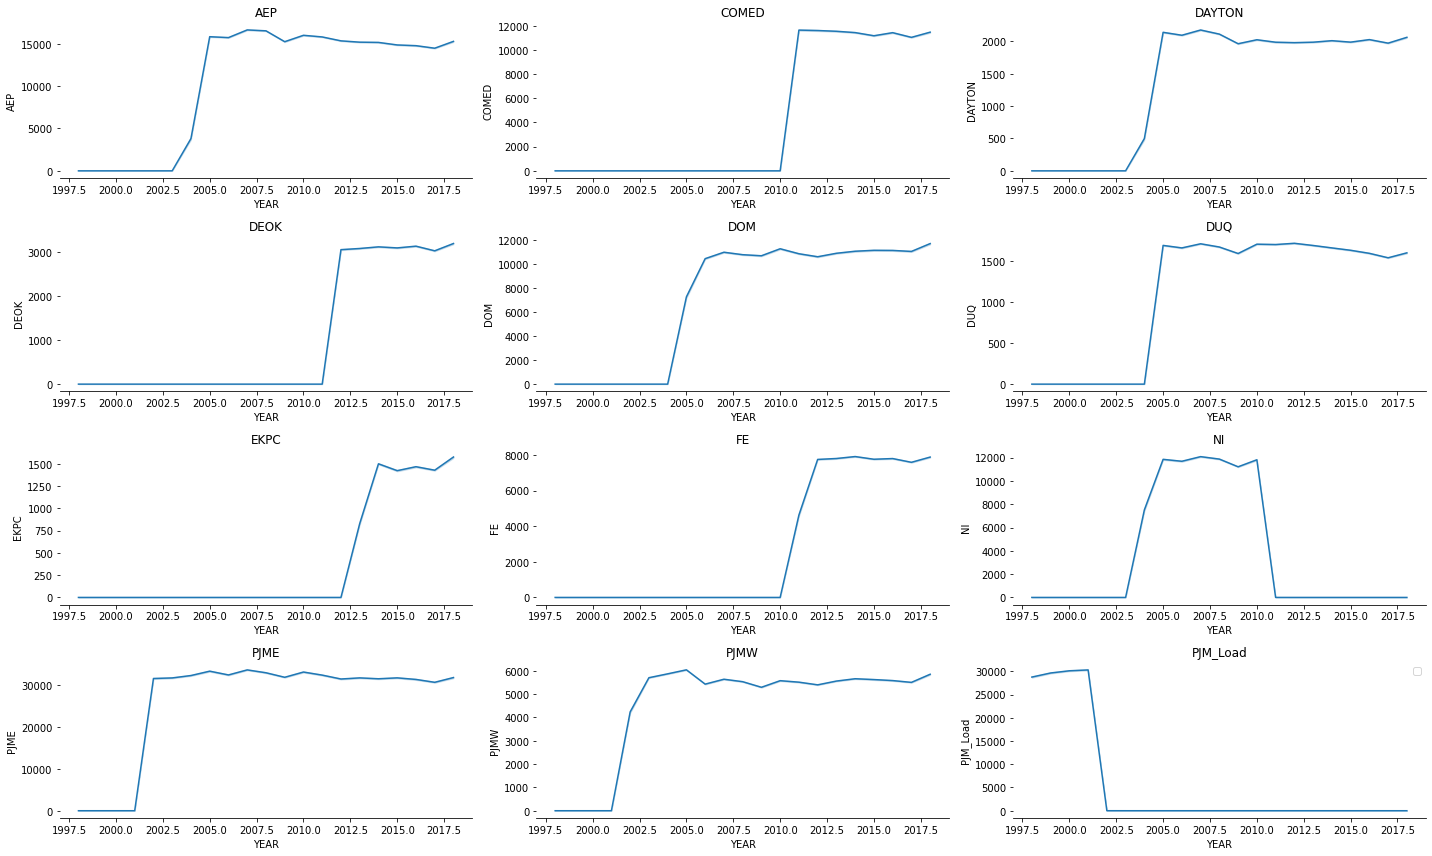

In [0]:
# Visualización de los datos en función de los años
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)

sns.lineplot(x=df['YEAR'],y=df['AEP'],ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df['YEAR'],y=df['COMED'],ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df['YEAR'],y=df['DAYTON'],ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df['YEAR'],y=df['DEOK'],ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df['YEAR'],y=df['DOM'],ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df['YEAR'],y=df['DUQ'],ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df['YEAR'],y=df['EKPC'],ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df['YEAR'],y=df['FE'],ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df['YEAR'],y=df['NI'],ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df['YEAR'],y=df['PJME'],ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df['YEAR'],y=df['PJMW'],ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df['YEAR'],y=df['PJM_Load'],ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

No handles with labels found to put in legend.


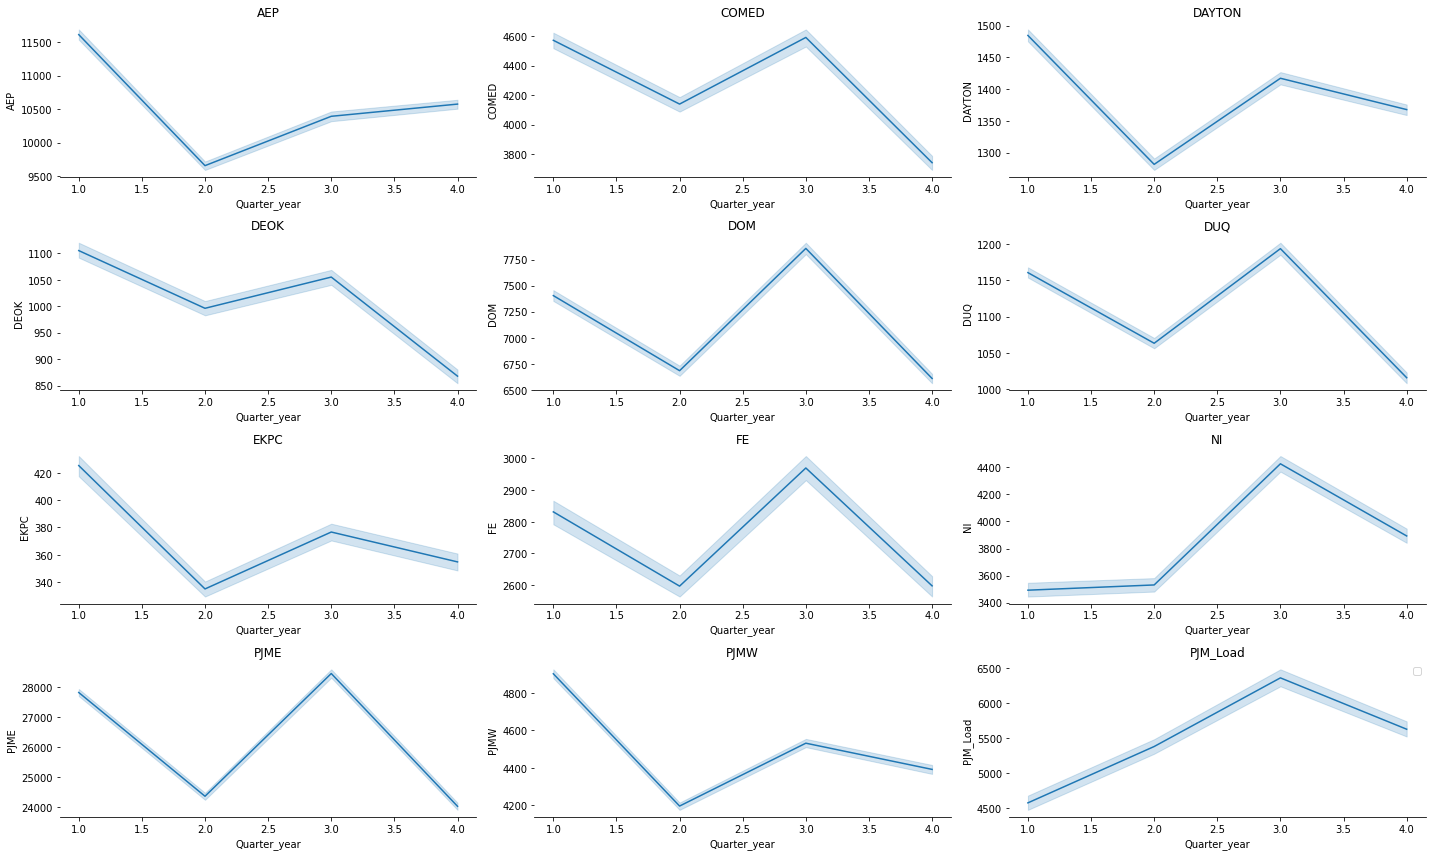

In [0]:
# Visualización de los datos en función del tiempo
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)

sns.lineplot(x=df['Quarter_year'],y=df['AEP'],data=df,ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df['Quarter_year'],y=df['COMED'],data=df,ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df['Quarter_year'],y=df['DAYTON'],data=df,ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df['Quarter_year'],y=df['DEOK'],data=df,ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df['Quarter_year'],y=df['DOM'],data=df,ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df['Quarter_year'],y=df['DUQ'],data=df,ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df['Quarter_year'],y=df['EKPC'],data=df,ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df['Quarter_year'],y=df['FE'],data=df,ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df['Quarter_year'],y=df['NI'],data=df,ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df['Quarter_year'],y=df['PJME'],data=df,ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df['Quarter_year'],y=df['PJMW'],data=df,ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df['Quarter_year'],y=df['PJM_Load'],data=df,ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

No handles with labels found to put in legend.


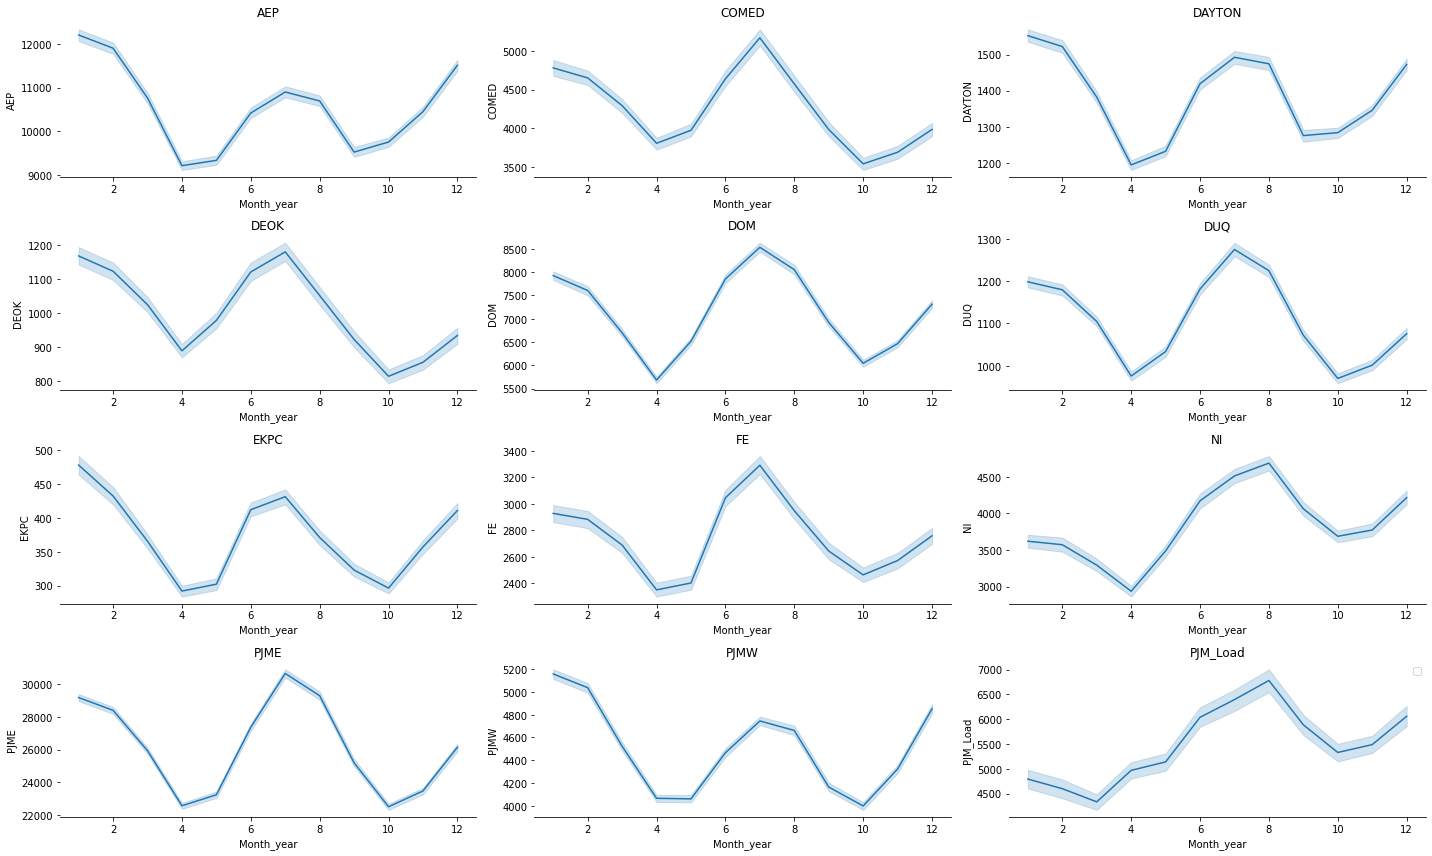

In [0]:
# Visualización de los datos en función del tiempo
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)

sns.lineplot(x=df['Month_year'],y=df['AEP'],data=df,ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df['Month_year'],y=df['COMED'],data=df,ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df['Month_year'],y=df['DAYTON'],data=df,ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df['Month_year'],y=df['DEOK'],data=df,ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df['Month_year'],y=df['DOM'],data=df,ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df['Month_year'],y=df['DUQ'],data=df,ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df['Month_year'],y=df['EKPC'],data=df,ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df['Month_year'],y=df['FE'],data=df,ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df['Month_year'],y=df['NI'],data=df,ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df['Month_year'],y=df['PJME'],data=df,ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df['Month_year'],y=df['PJMW'],data=df,ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df['Month_year'],y=df['PJM_Load'],data=df,ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

No handles with labels found to put in legend.


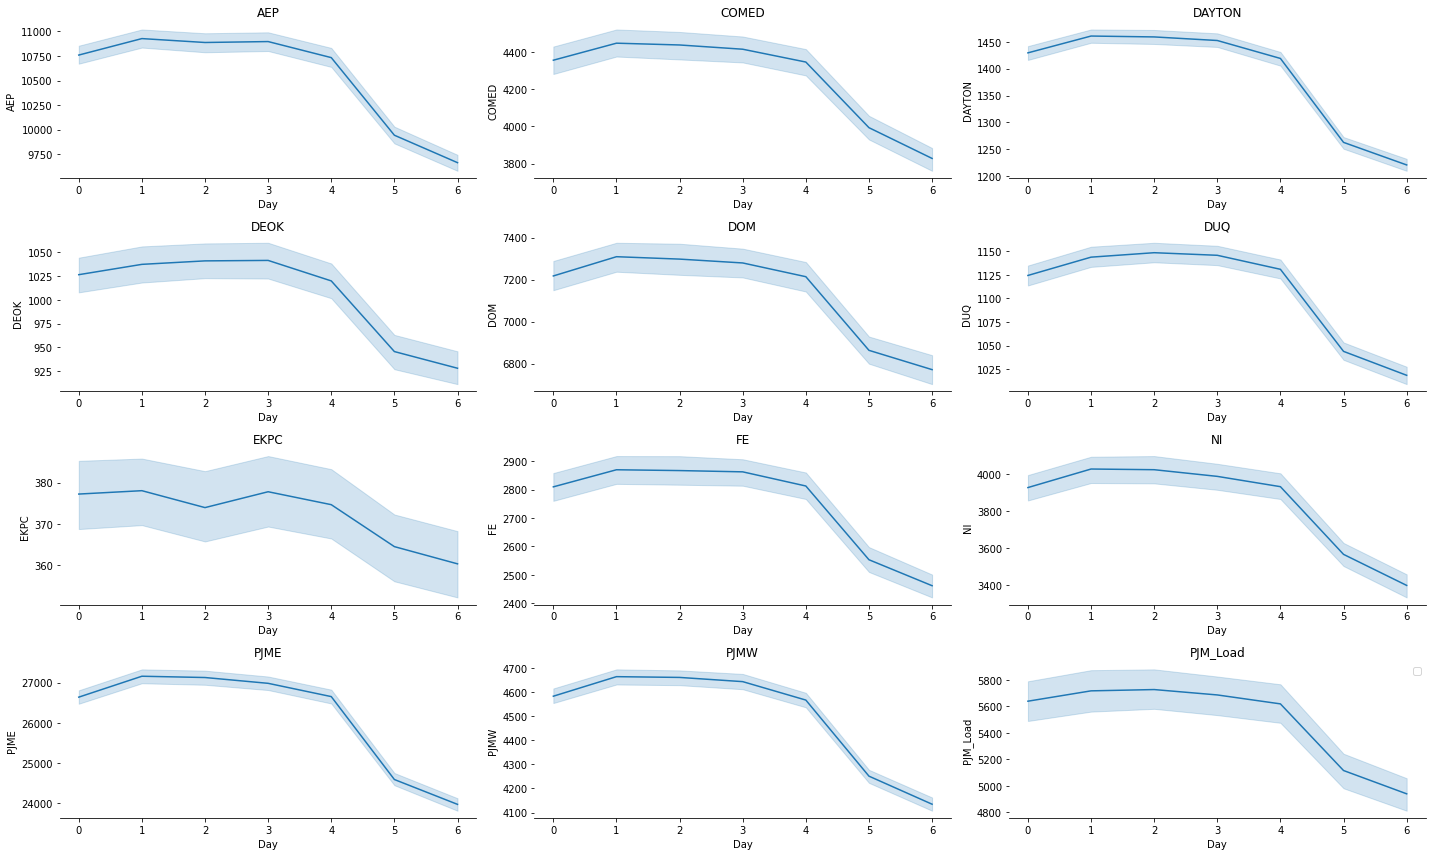

In [0]:
# Visualización de los datos en función del tiempo
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)

sns.lineplot(x=df['Day'],y=df['AEP'],data=df,ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df['Day'],y=df['COMED'],data=df,ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df['Day'],y=df['DAYTON'],data=df,ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df['Day'],y=df['DEOK'],data=df,ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df['Day'],y=df['DOM'],data=df,ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df['Day'],y=df['DUQ'],data=df,ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df['Day'],y=df['EKPC'],data=df,ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df['Day'],y=df['FE'],data=df,ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df['Day'],y=df['NI'],data=df,ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df['Day'],y=df['PJME'],data=df,ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df['Day'],y=df['PJMW'],data=df,ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df['Day'],y=df['PJM_Load'],data=df,ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

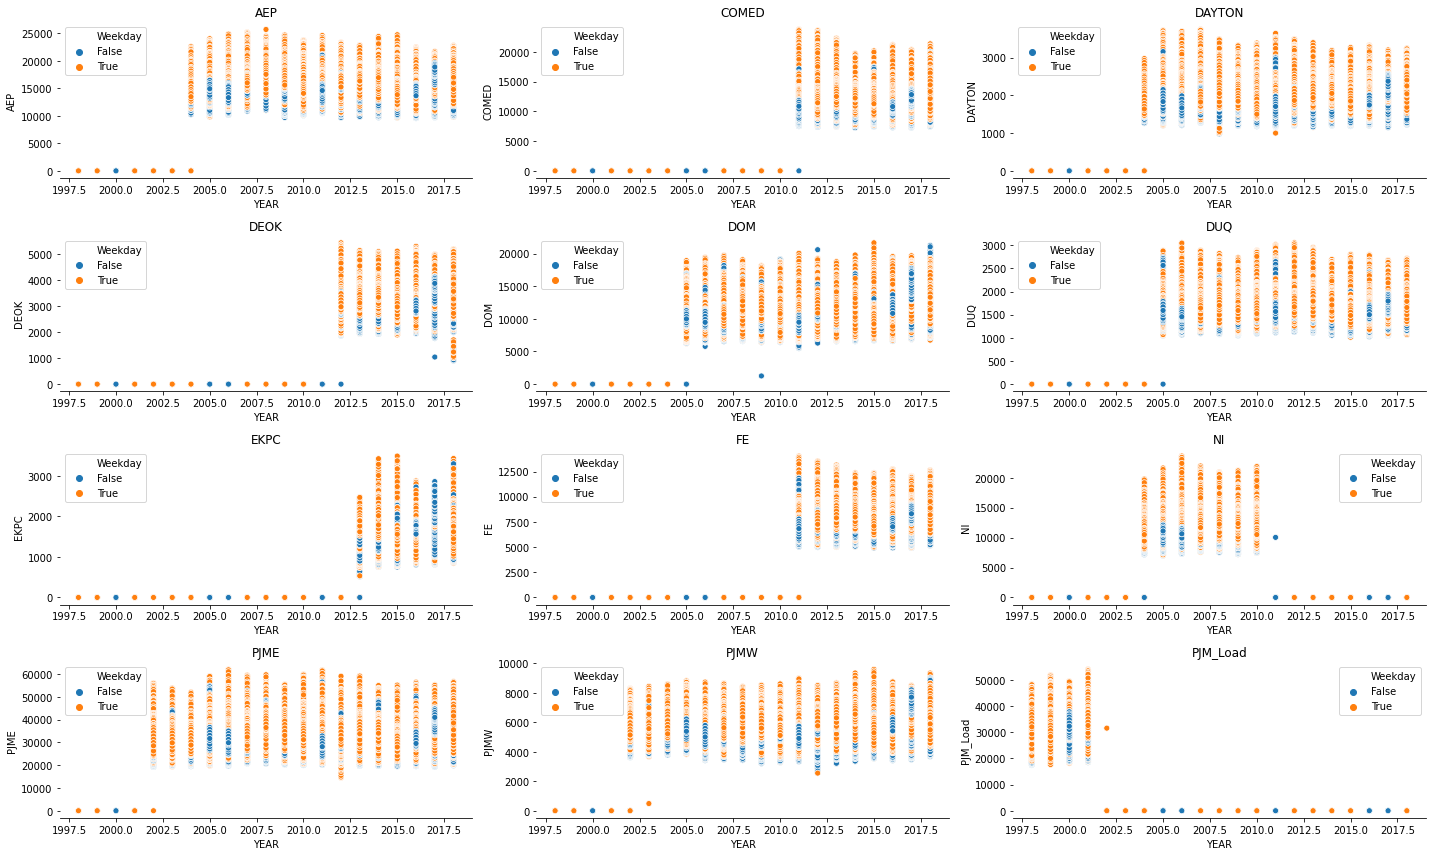

In [0]:
# Visualización de los datos en función del tiempo
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)
sns.scatterplot(x="YEAR", y="AEP", hue="Weekday", data=df, ax=axes[0, 0]).set_title('AEP')
sns.scatterplot(x="YEAR", y=df['COMED'], hue="Weekday", data=df, ax=axes[0, 1]).set_title('COMED')
sns.scatterplot(x="YEAR", y=df['DAYTON'], hue="Weekday", data=df, ax=axes[0, 2]).set_title('DAYTON')
sns.scatterplot(x="YEAR", y=df['DEOK'], hue="Weekday", data=df, ax=axes[1, 0]).set_title('DEOK')
sns.scatterplot(x="YEAR", y=df['DOM'], hue="Weekday", data=df, ax=axes[1, 1]).set_title('DOM')
sns.scatterplot(x="YEAR", y=df['DUQ'], hue="Weekday", data=df, ax=axes[1, 2]).set_title('DUQ')
sns.scatterplot(x="YEAR", y=df['EKPC'], hue="Weekday", data=df, ax=axes[2, 0]).set_title('EKPC')
sns.scatterplot(x="YEAR", y=df['FE'], hue="Weekday", data=df, ax=axes[2, 1]).set_title('FE')
sns.scatterplot(x="YEAR", y=df['NI'], hue="Weekday", data=df, ax=axes[2, 2]).set_title('NI')
sns.scatterplot(x="YEAR", y=df['PJME'], hue="Weekday", data=df, ax=axes[3, 0]).set_title('PJME')
sns.scatterplot(x="YEAR", y=df['PJMW'], hue="Weekday", data=df, ax=axes[3, 1]).set_title('PJMW')
sns.scatterplot(x="YEAR", y=df['PJM_Load'], hue="Weekday", data=df, ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

In [0]:
df.keys()
for key in df.keys():
  if(key in ["AEP","COMED","DAYTON","DEOK","DOM","DUQ","EKPC","FE","NI","PJME","PJMW","PJM_Load"]):
    df_range=df[(df['Datetime']>=range_values[key]['start']) & (df['Datetime']<=range_values[key]['end'])][key]
    print(df_range.describe().T)

#  df_range.describe().T

count    121300.000000
mean      15499.039580
std        2591.441738
min        9581.000000
25%       13629.000000
50%       15309.000000
75%       17200.000000
max       25695.000000
Name: AEP, dtype: float64
count    66508.000000
mean     11419.805512
std       2304.114609
min       7237.000000
25%       9779.000000
50%      11151.000000
75%      12510.000000
max      23753.000000
Name: COMED, dtype: float64
count    121300.000000
mean       2037.755829
std         393.429469
min         982.000000
25%        1749.000000
50%        2009.000000
75%        2279.000000
max        3746.000000
Name: DAYTON, dtype: float64
count    57748.000000
mean      3105.000745
std        599.865854
min        907.000000
25%       2687.000000
50%       3013.000000
75%       3449.000000
max       5445.000000
Name: DEOK, dtype: float64
count    116212.000000
mean      10948.784471
std        2414.001312
min        1253.000000
25%        9322.000000
50%       10501.000000
75%       12378.000000
max      

No handles with labels found to put in legend.


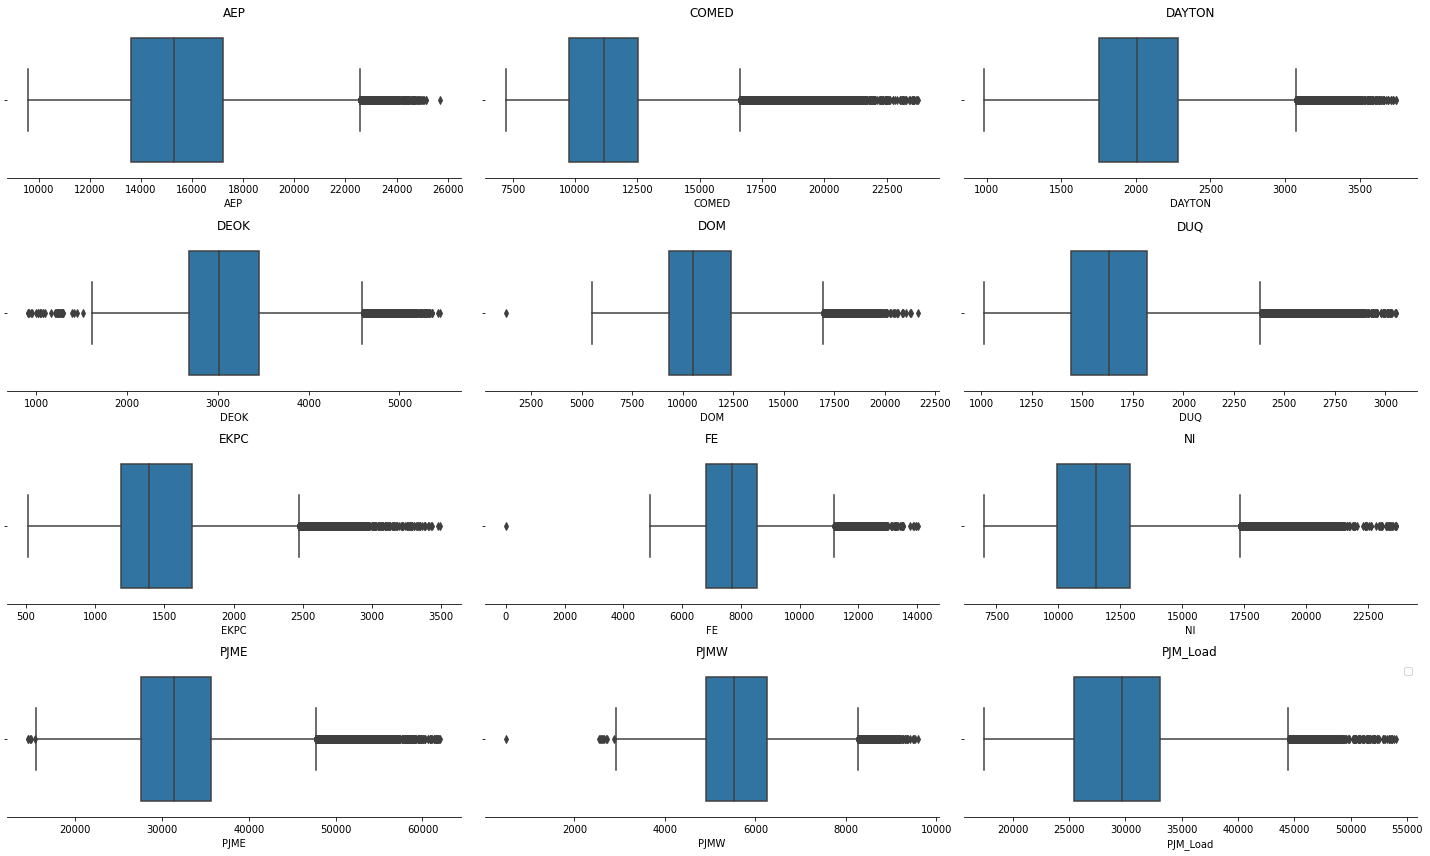

In [0]:
# Visualización de los boxplot
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(4, 3, figsize=(20, 12))
sns.despine(left=True)

sns.boxplot(x=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]['AEP'],ax=axes[0, 0]).set_title('AEP')
sns.boxplot(x=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]['COMED'],ax=axes[0, 1]).set_title('COMED')
sns.boxplot(x=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]['DAYTON'],ax=axes[0, 2]).set_title('DAYTON')
sns.boxplot(x=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]['DEOK'],ax=axes[1, 0]).set_title('DEOK')
sns.boxplot(x=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]['DOM'],ax=axes[1, 1]).set_title('DOM')
sns.boxplot(x=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]['DUQ'],ax=axes[1, 2]).set_title('DUQ')
sns.boxplot(x=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]['EKPC'],ax=axes[2, 0]).set_title('EKPC')
sns.boxplot(x=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]['FE'],ax=axes[2, 1]).set_title('FE')
sns.boxplot(x=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]['NI'],ax=axes[2, 2]).set_title('NI')
sns.boxplot(x=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]['PJME'],ax=axes[3, 0]).set_title('PJME')
sns.boxplot(x=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]['PJMW'],ax=axes[3, 1]).set_title('PJMW')
sns.boxplot(x=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]['PJM_Load'],ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();
#ax = sns.boxplot(x=df["AEP"])
#plt.show()

In [0]:
#df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end']) & (df['DOM']==0)]
df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end']) & (df['FE']==0)]
#df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end']) & (df['PJMW']==0)]

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,DATE,TIME,YEAR,Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend,Quarter_year,Month_year,Week_year,Day_year
115416,2011-06-01 01:00:00,16407.0,11714.0,2126.0,0.0,11365.0,2047.0,0.0,0.0,0.0,34591.0,5617.0,0.0,2011-06-01,01:00:00,2011,2,False,False,True,False,False,False,False,True,False,2,6,22,152


In [0]:
#df.iloc[df.index.get_loc(df[df['Datetime']=="2011-06-01 01:00:00"]),'FE']=df[df['Datetime']=="2011-06-01 02:00:00"]['FE']
#df[df['Datetime']=="2011-06-01 01:00:00"]['FE']
range_values['FE']['start']="2011-06-01 02:00:00"

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

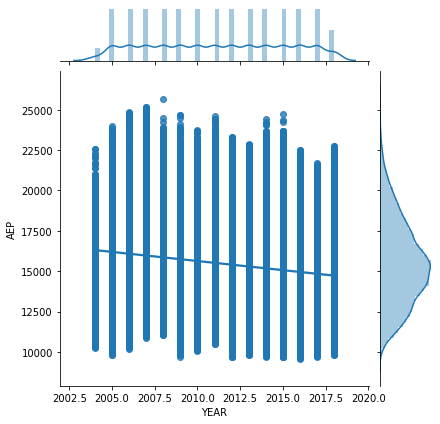

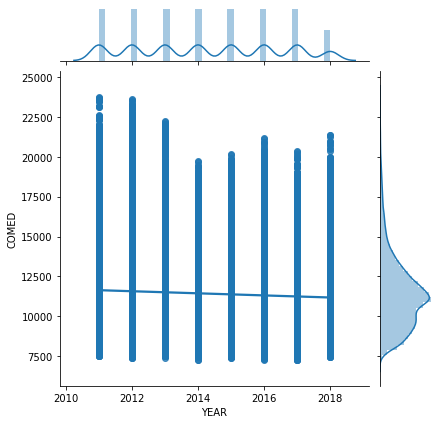

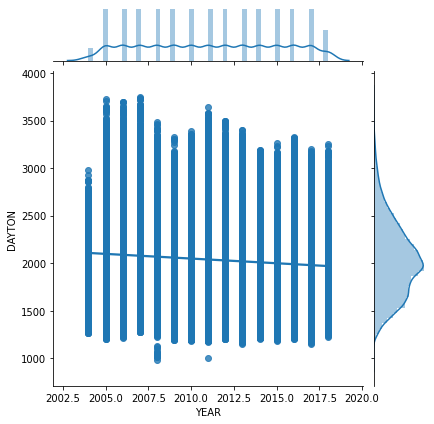

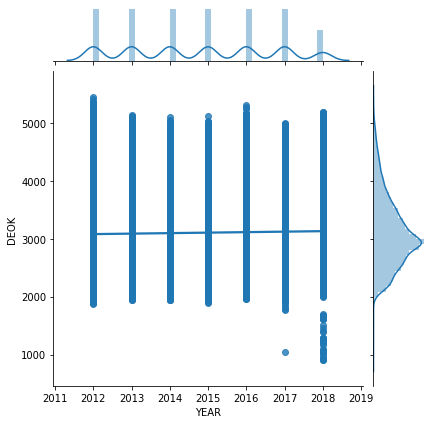

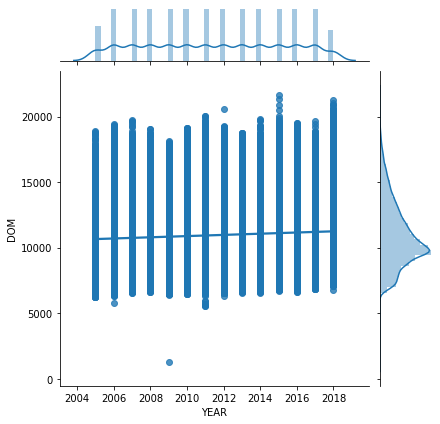

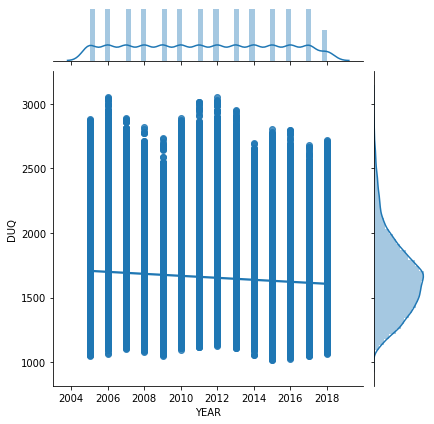

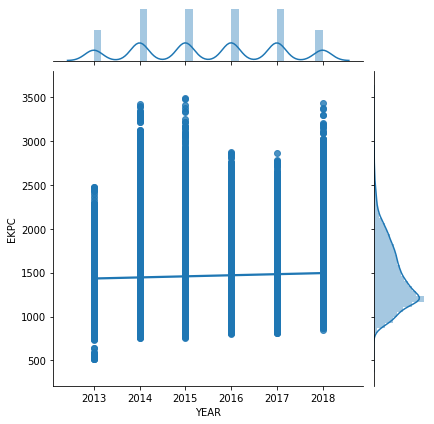

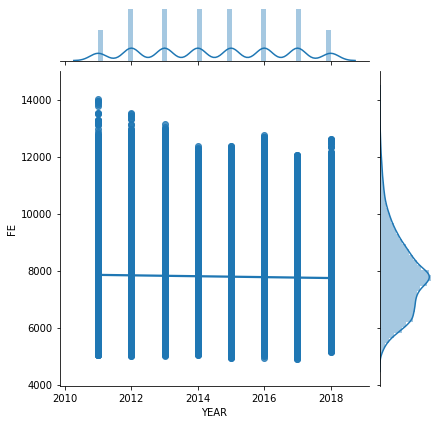

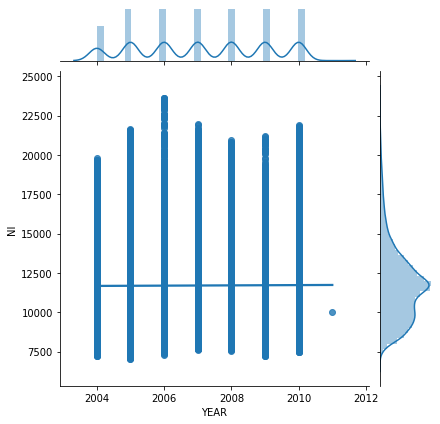

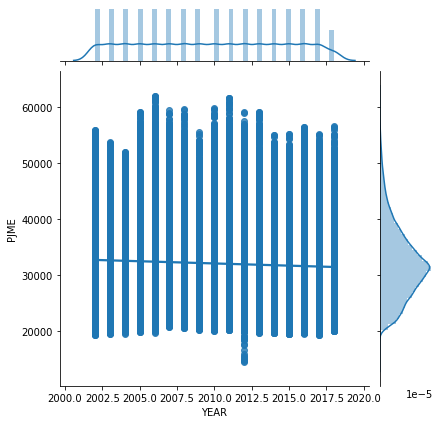

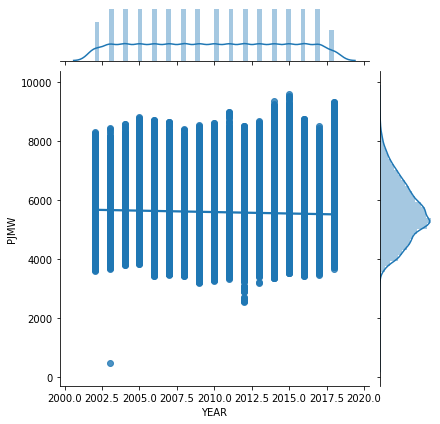

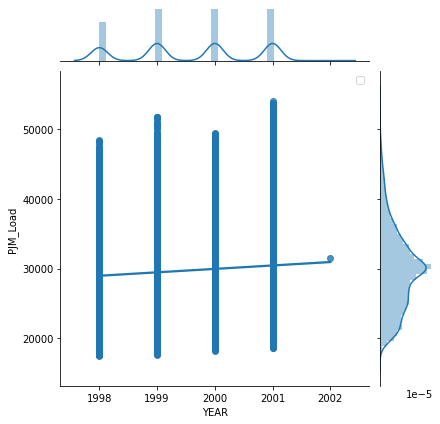

In [0]:
# Regresión de los datos en función de los años

plt.figure(1)
sns.jointplot(x=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]['AEP'],kind="reg")
plt.figure(2)
sns.jointplot(x=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]['COMED'],kind="reg")
plt.figure(3)
sns.jointplot(x=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]['DAYTON'],kind="reg")
plt.figure(4)
sns.jointplot(x=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]['DEOK'],kind="reg")
plt.figure(5)
sns.jointplot(x=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]['DOM'],kind="reg")
plt.figure(6)
sns.jointplot(x=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]['DUQ'],kind="reg")
plt.figure(7)
sns.jointplot(x=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]['EKPC'],kind="reg")
plt.figure(8)
sns.jointplot(x=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]['FE'],kind="reg")
plt.figure(9)
sns.jointplot(x=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]['NI'],kind="reg")
plt.figure(10)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]['PJME'],kind="reg")
plt.figure(11)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]['PJMW'],kind="reg")
plt.figure(12)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]['PJM_Load'],kind="reg")
plt.legend();

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

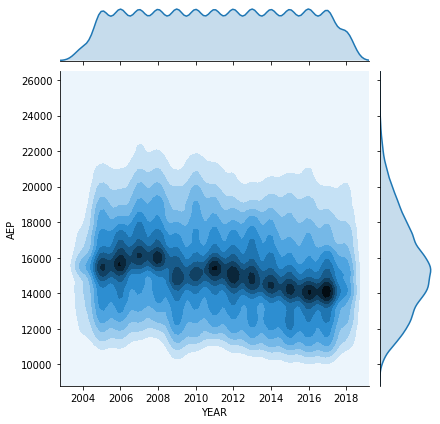

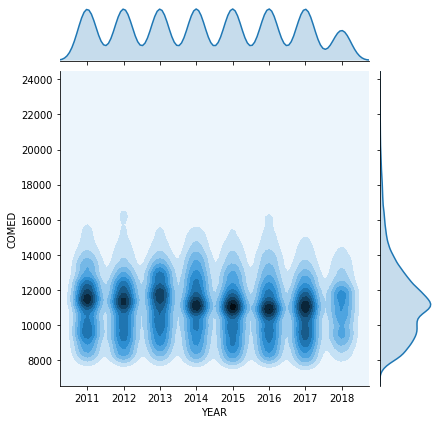

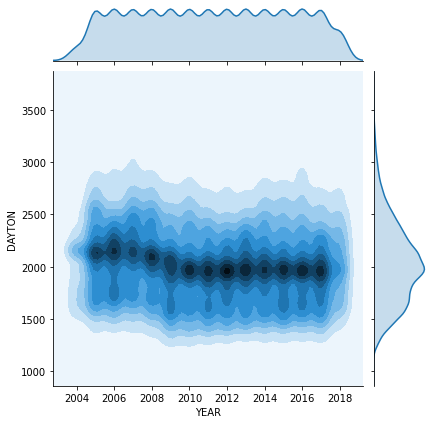

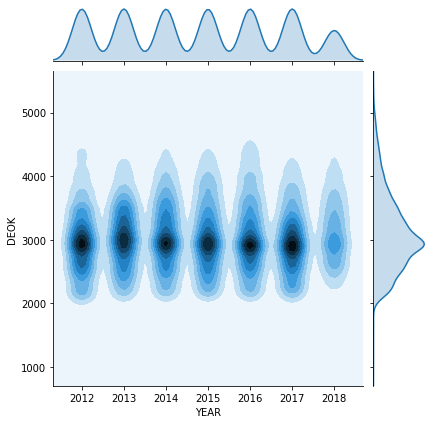

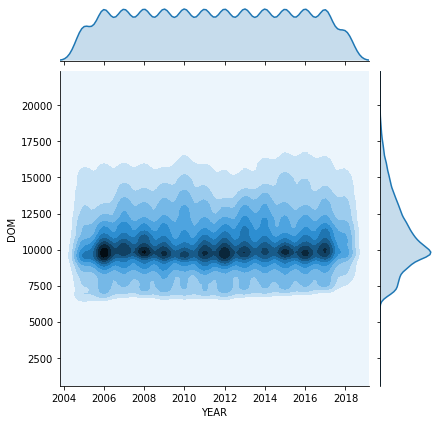

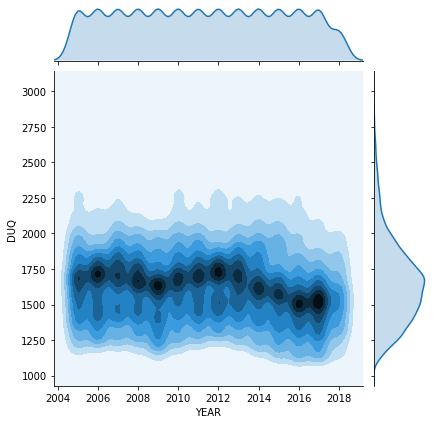

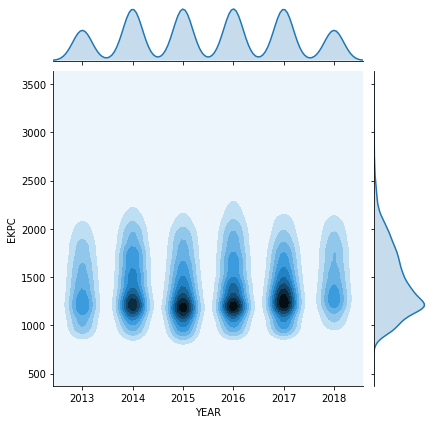

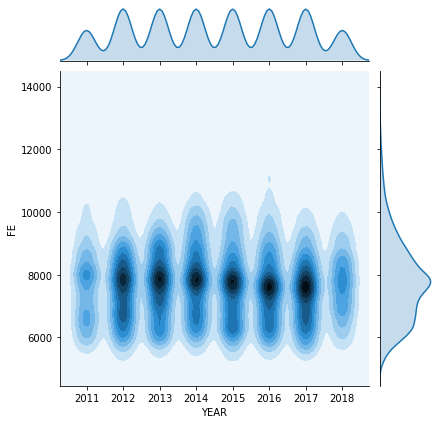

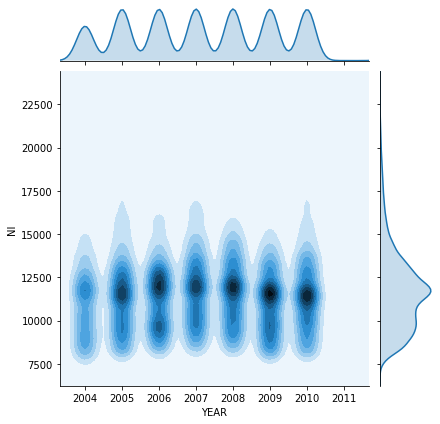

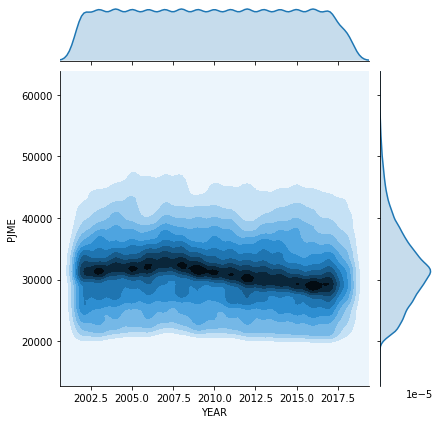

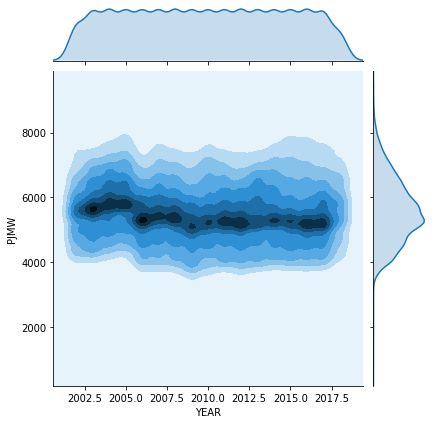

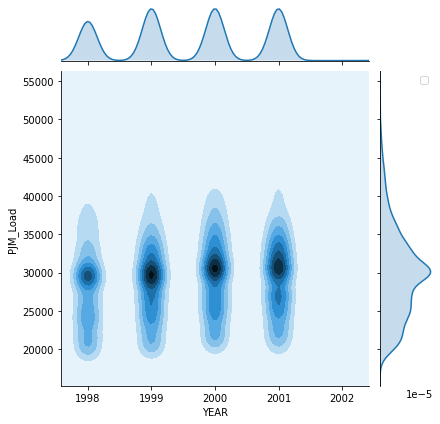

In [0]:
# Regresión de los datos en función de los años
plt.figure(1)
sns.jointplot(x=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]["AEP"], data=df,kind="kde")
plt.figure(2)
sns.jointplot(x=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]["COMED"], data=df,kind="kde")
plt.figure(3)
sns.jointplot(x=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]["DAYTON"], data=df,kind="kde")
plt.figure(4)
sns.jointplot(x=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]["DEOK"], data=df,kind="kde")
plt.figure(5)
sns.jointplot(x=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]["DOM"], data=df,kind="kde")
plt.figure(6)
sns.jointplot(x=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]["DUQ"], data=df,kind="kde")
plt.figure(7)
sns.jointplot(x=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]["EKPC"], data=df,kind="kde")
plt.figure(8)
sns.jointplot(x=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]["FE"], data=df,kind="kde")
plt.figure(9)
sns.jointplot(x=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]["NI"], data=df,kind="kde")
plt.figure(10)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]["PJME"], data=df,kind="kde")
plt.figure(11)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]["PJMW"], data=df,kind="kde")
plt.figure(12)
sns.jointplot(x=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]["YEAR"], y=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]["PJM_Load"], data=df,kind="kde")
plt.legend();

No handles with labels found to put in legend.


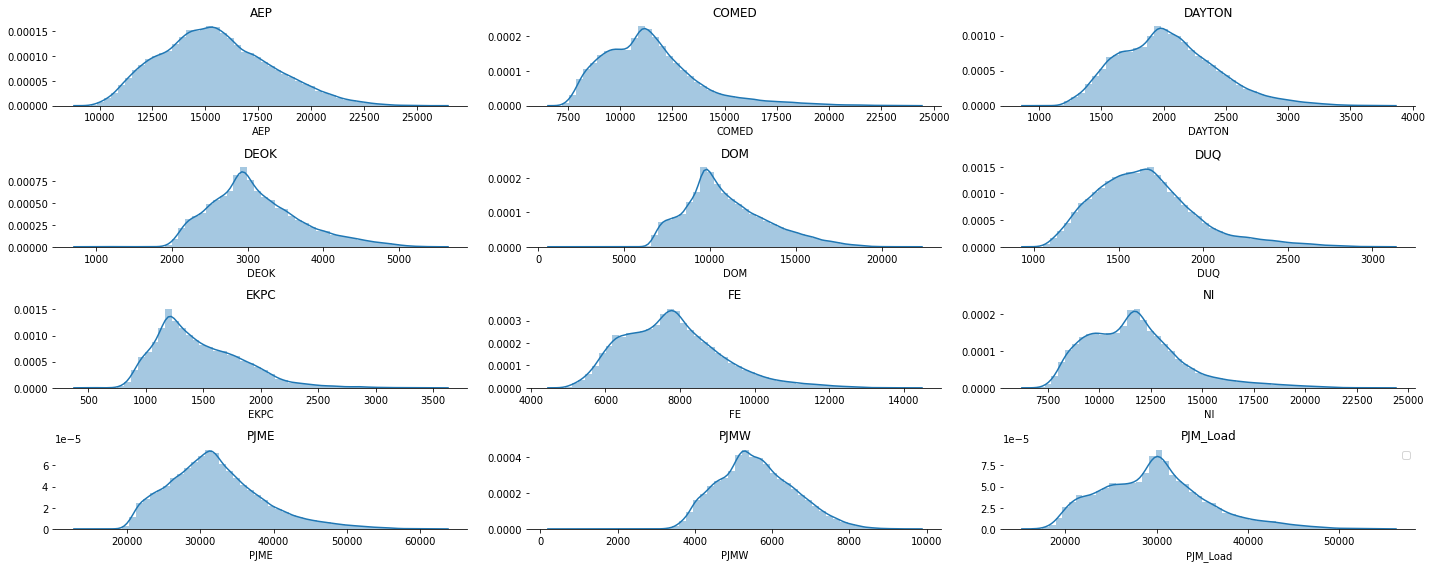

In [0]:
# Distribución de los datos
f, axes = plt.subplots(4, 3, figsize=(20, 8))
sns.despine(left=True)

sns.distplot(df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]['AEP'],ax=axes[0, 0]).set_title('AEP')
sns.distplot(df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]['COMED'],ax=axes[0, 1]).set_title('COMED')
sns.distplot(df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]['DAYTON'],ax=axes[0, 2]).set_title('DAYTON')
sns.distplot(df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]['DEOK'],ax=axes[1, 0]).set_title('DEOK')
sns.distplot(df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]['DOM'],ax=axes[1, 1]).set_title('DOM')
sns.distplot(df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]['DUQ'],ax=axes[1, 2]).set_title('DUQ')
sns.distplot(df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]['EKPC'],ax=axes[2, 0]).set_title('EKPC')
sns.distplot(df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]['FE'],ax=axes[2, 1]).set_title('FE')
sns.distplot(df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]['NI'],ax=axes[2, 2]).set_title('NI')
sns.distplot(df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]['PJME'],ax=axes[3, 0]).set_title('PJME')
sns.distplot(df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]['PJMW'],ax=axes[3, 1]).set_title('PJMW')
sns.distplot(df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]['PJM_Load'],ax=axes[3, 2]).set_title('PJM_Load')
f.tight_layout()
plt.legend();

No handles with labels found to put in legend.


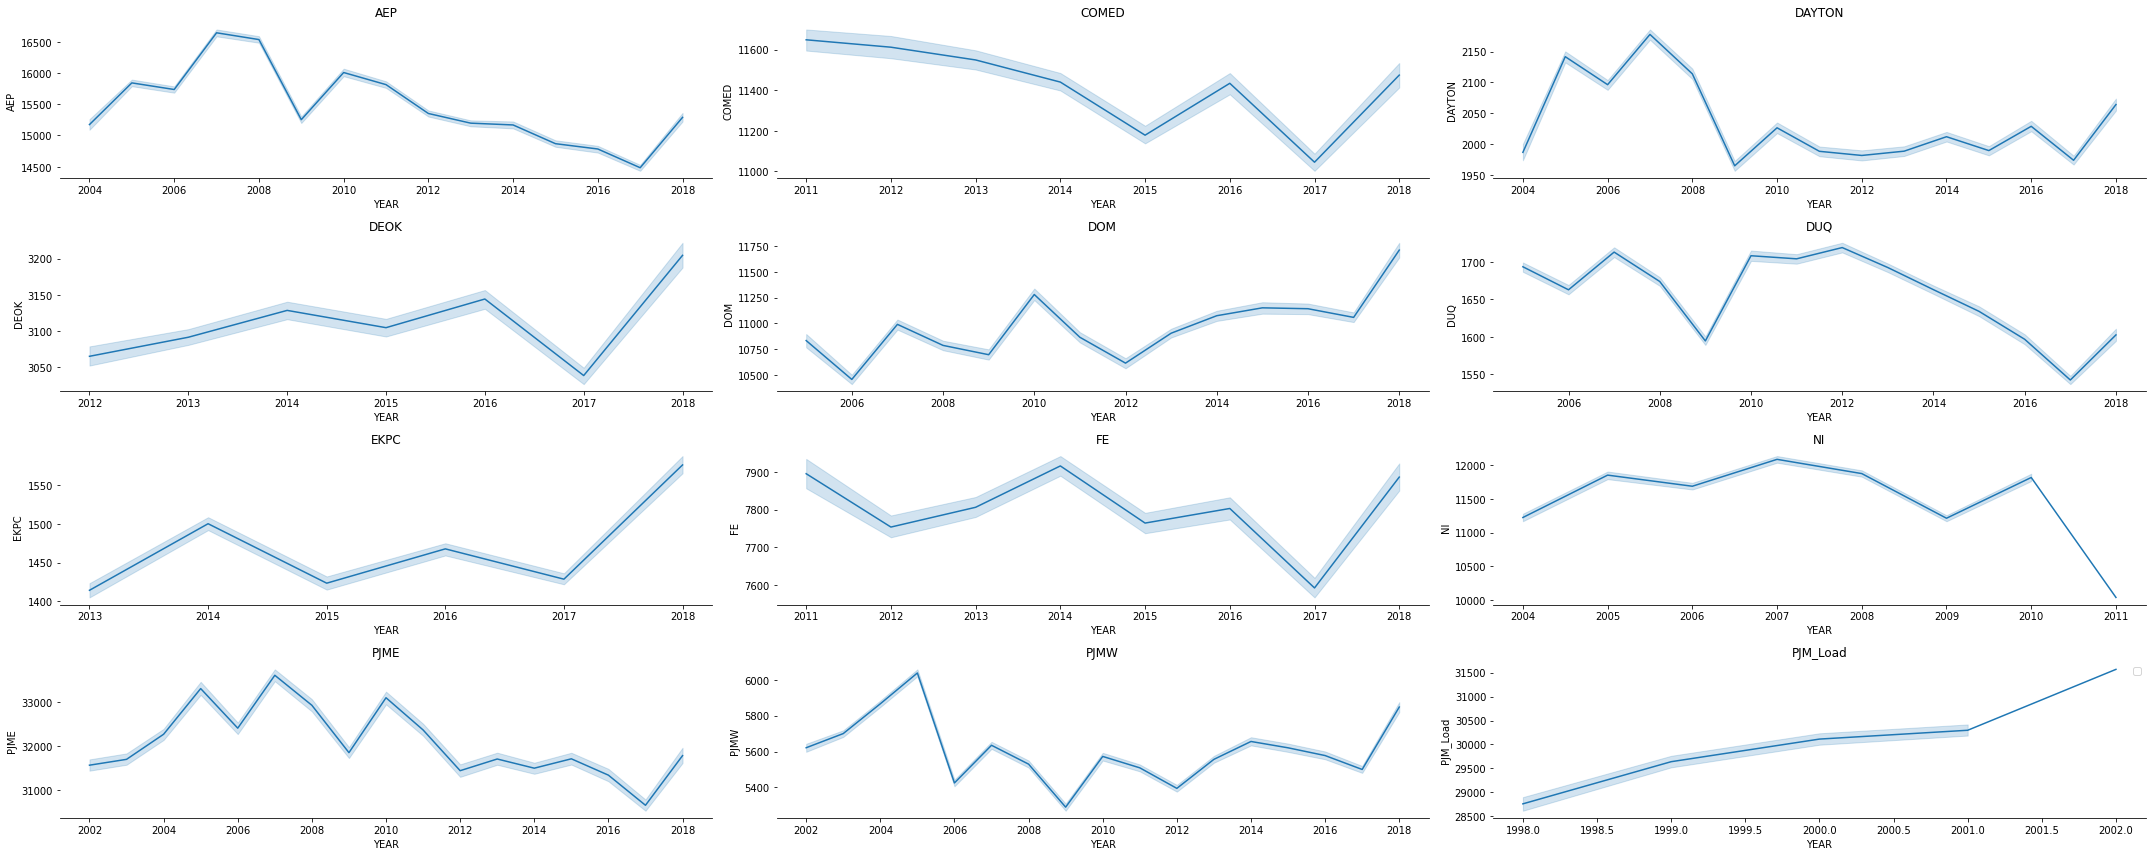

In [0]:
# gráfica de consumo
f, axes = plt.subplots(4, 3, figsize=(30, 12))
sns.despine(left=True)

sns.lineplot(x=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['AEP']['start']) & (df['Datetime']<=range_values['AEP']['end'])]['AEP'],ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['COMED']['start']) & (df['Datetime']<=range_values['COMED']['end'])]['COMED'],ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['DAYTON']['start']) & (df['Datetime']<=range_values['DAYTON']['end'])]['DAYTON'],ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['DEOK']['start']) & (df['Datetime']<=range_values['DEOK']['end'])]['DEOK'],ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['DOM']['start']) & (df['Datetime']<=range_values['DOM']['end'])]['DOM'],ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['DUQ']['start']) & (df['Datetime']<=range_values['DUQ']['end'])]['DUQ'],ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['EKPC']['start']) & (df['Datetime']<=range_values['EKPC']['end'])]['EKPC'],ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['FE']['start']) & (df['Datetime']<=range_values['FE']['end'])]['FE'],ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['NI']['start']) & (df['Datetime']<=range_values['NI']['end'])]['NI'],ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['PJME']['start']) & (df['Datetime']<=range_values['PJME']['end'])]['PJME'],ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['PJMW']['start']) & (df['Datetime']<=range_values['PJMW']['end'])]['PJMW'],ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]['YEAR'],y=df[(df['Datetime']>=range_values['PJM_Load']['start']) & (df['Datetime']<=range_values['PJM_Load']['end'])]['PJM_Load'],ax=axes[3, 2]).set_title('PJM_Load')

f.tight_layout()
plt.legend();

## 7 Análisis predictivo.

### Modelo XGBoost

No handles with labels found to put in legend.


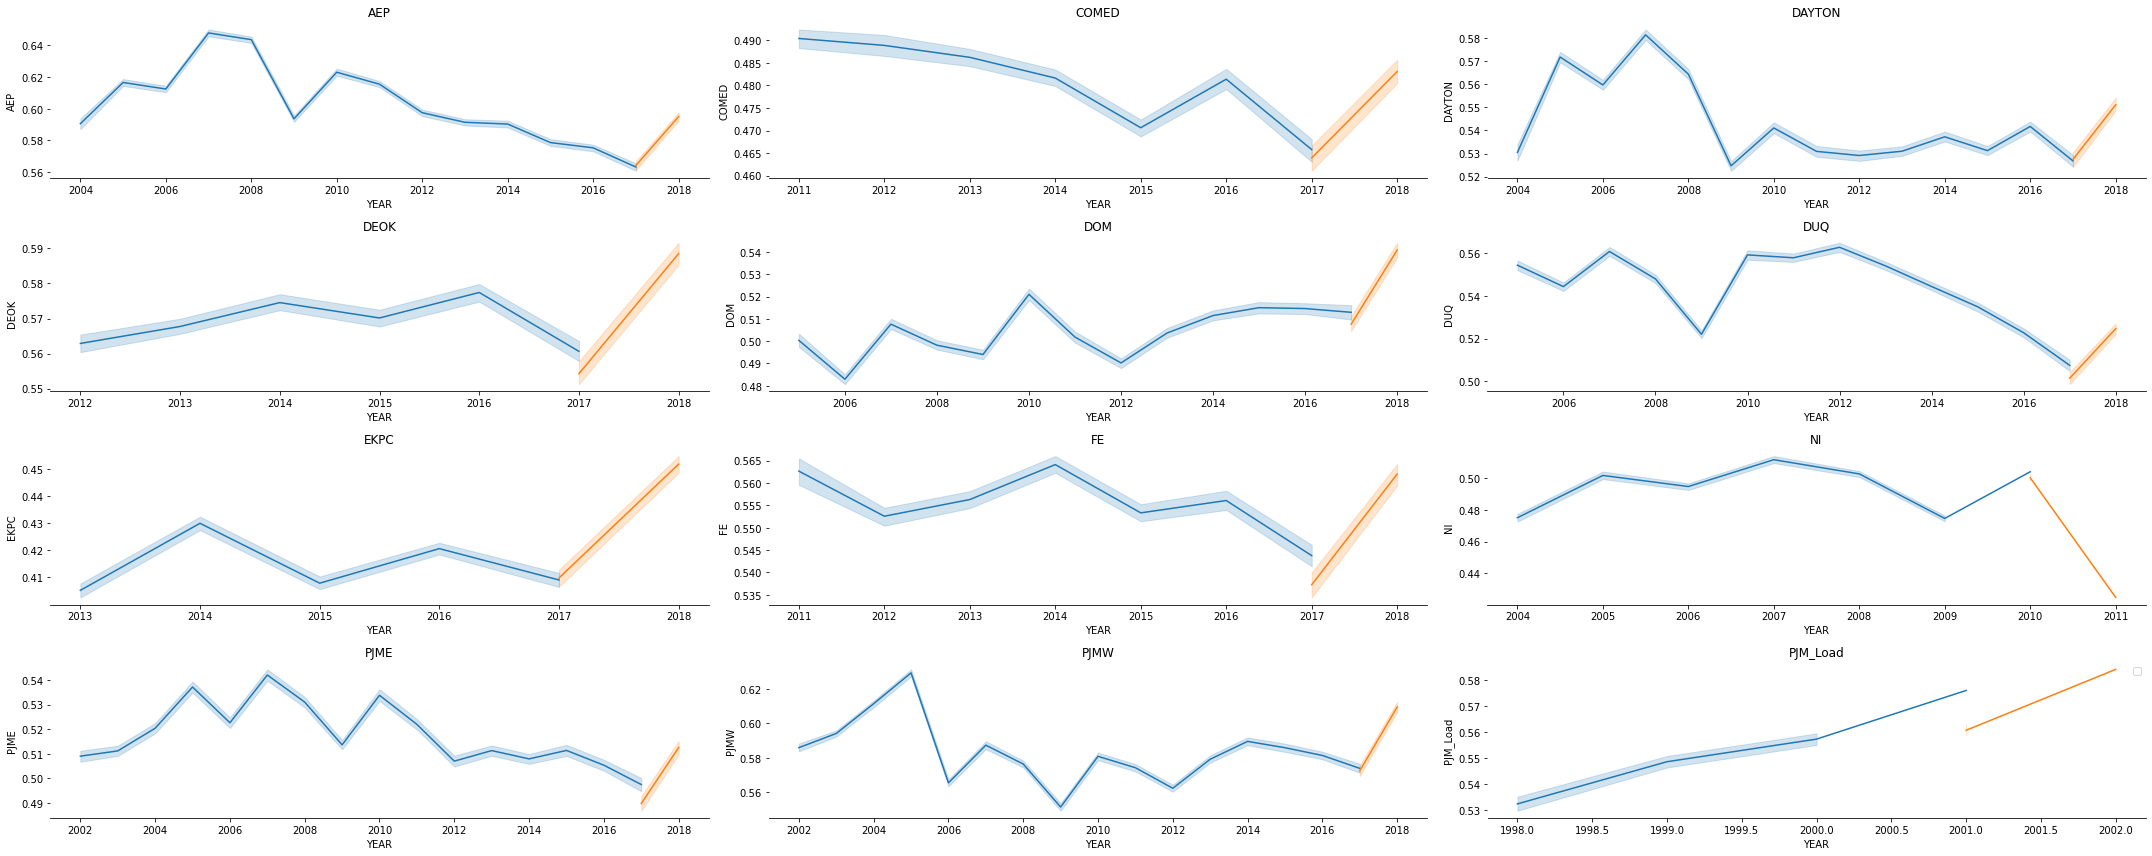

In [0]:
#divido train y test
test_hours = 24*365 #un año
df_splited = {}
for key in range_values:
  if(key=='AEP' or key=='COMED' or key=='DAYTON' or key=='DEOK' or key=='DOM' or key=='DUQ' or key=='EKPC' or key=='FE' or key=='NI' or key=='PJME' or key=='PJMW' or key=='PJM_Load'):
    partial_df=df_normalized[(df_normalized['Datetime']>=range_values[key]['start']) & (df_normalized['Datetime']<=range_values[key]['end'])][['Datetime',key,'DATE','TIME','YEAR','Hour', 'Day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Weekday','Weekend','Quarter_year','Month_year','Week_year','Day_year']]
    df_splited[key]={'total':partial_df,'x_train':partial_df[:(len(partial_df)-test_hours)][['YEAR','Hour', 'Day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Weekday','Weekend','Quarter_year','Month_year','Week_year','Day_year']],'y_train':partial_df[:(len(partial_df)-test_hours)][key],'x_test':partial_df[(len(partial_df)-test_hours):][['YEAR','Hour','Day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Weekday','Weekend','Quarter_year','Month_year','Week_year','Day_year']],'y_test':partial_df[(len(partial_df)-test_hours):][key]}
    #print(partial_df.shape,df_splited[key]['train'].shape,df_splited[key]['test'].shape)
  
# gráfica de consumo train/test
f, axes = plt.subplots(4, 3, figsize=(30, 12))
sns.despine(left=True)

sns.lineplot(x=df_splited['AEP']['x_train']['YEAR'], y=df_splited['AEP']['y_train'], ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df_splited['AEP']['x_test']['YEAR'], y=df_splited['AEP']['y_test'], ax=axes[0, 0]).set_title('AEP')

sns.lineplot(x=df_splited['COMED']['x_train']['YEAR'],y=df_splited['COMED']['y_train'],ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df_splited['COMED']['x_test']['YEAR'],y=df_splited['COMED']['y_test'],ax=axes[0, 1]).set_title('COMED')

sns.lineplot(x=df_splited['DAYTON']['x_train']['YEAR'],y=df_splited['DAYTON']['y_train'],ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df_splited['DAYTON']['x_test']['YEAR'],y=df_splited['DAYTON']['y_test'],ax=axes[0, 2]).set_title('DAYTON')

sns.lineplot(x=df_splited['DEOK']['x_train']['YEAR'],y=df_splited['DEOK']['y_train'],ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df_splited['DEOK']['x_test']['YEAR'],y=df_splited['DEOK']['y_test'],ax=axes[1, 0]).set_title('DEOK')

sns.lineplot(x=df_splited['DOM']['x_train']['YEAR'],y=df_splited['DOM']['y_train'],ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df_splited['DOM']['x_test']['YEAR'],y=df_splited['DOM']['y_test'],ax=axes[1, 1]).set_title('DOM')

sns.lineplot(x=df_splited['DUQ']['x_train']['YEAR'],y=df_splited['DUQ']['y_train'],ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df_splited['DUQ']['x_test']['YEAR'],y=df_splited['DUQ']['y_test'],ax=axes[1, 2]).set_title('DUQ')

sns.lineplot(x=df_splited['EKPC']['x_train']['YEAR'],y=df_splited['EKPC']['y_train'],ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df_splited['EKPC']['x_test']['YEAR'],y=df_splited['EKPC']['y_test'],ax=axes[2, 0]).set_title('EKPC')

sns.lineplot(x=df_splited['FE']['x_train']['YEAR'],y=df_splited['FE']['y_train'],ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df_splited['FE']['x_test']['YEAR'],y=df_splited['FE']['y_test'],ax=axes[2, 1]).set_title('FE')

sns.lineplot(x=df_splited['NI']['x_train']['YEAR'],y=df_splited['NI']['y_train'],ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df_splited['NI']['x_test']['YEAR'],y=df_splited['NI']['y_test'],ax=axes[2, 2]).set_title('NI')

sns.lineplot(x=df_splited['PJME']['x_train']['YEAR'],y=df_splited['PJME']['y_train'],ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df_splited['PJME']['x_test']['YEAR'],y=df_splited['PJME']['y_test'],ax=axes[3, 0]).set_title('PJME')

sns.lineplot(x=df_splited['PJMW']['x_train']['YEAR'],y=df_splited['PJMW']['y_train'],ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df_splited['PJMW']['x_test']['YEAR'],y=df_splited['PJMW']['y_test'],ax=axes[3, 1]).set_title('PJMW')

sns.lineplot(x=df_splited['PJM_Load']['x_train']['YEAR'],y=df_splited['PJM_Load']['y_train'],ax=axes[3, 2]).set_title('PJM_Load')
sns.lineplot(x=df_splited['PJM_Load']['x_test']['YEAR'],y=df_splited['PJM_Load']['y_test'],ax=axes[3, 2]).set_title('PJM_Load')

f.tight_layout()
plt.legend();

In [0]:
df_splited['AEP']['x_train'].tail()

,YEAR,Hour,Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekday,Weekend,Quarter_year,Month_year,Week_year,Day_year
169535,2017,21,2,False,False,True,False,False,False,False,True,False,3,8,31,214
169536,2017,22,2,False,False,True,False,False,False,False,True,False,3,8,31,214
169537,2017,23,2,False,False,True,False,False,False,False,True,False,3,8,31,214
169538,2017,0,3,False,False,False,True,False,False,False,True,False,3,8,31,215
169539,2017,1,3,False,False,False,True,False,False,False,True,False,3,8,31,215


In [0]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(df_splited['AEP']['x_train'], df_splited['AEP']['y_train'],
        eval_set=[(df_splited['AEP']['x_train'], df_splited['AEP']['y_train']), (df_splited['AEP']['x_test'], df_splited['AEP']['y_test'])],
        early_stopping_rounds=50,
        verbose=True)

[15:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.135316	validation_1-rmse:0.116271
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.126327	validation_1-rmse:0.108007
[2]	validation_0-rmse:0.118538	validation_1-rmse:0.102474
[3]	validation_0-rmse:0.11175	validation_1-rmse:0.096649
[4]	validation_0-rmse:0.105914	validation_1-rmse:0.091965
[5]	validation_0-rmse:0.100765	validation_1-rmse:0.08858
[6]	validation_0-rmse:0.09635	validation_1-rmse:0.085737
[7]	validation_0-rmse:0.092616	validation_1-rmse:0.082918
[8]	validation_0-rmse:0.088532	validation_1-rmse:0.079766
[9]	validation_0-rmse:0.08492	validation_1-rmse:0.077079
[10]	validation_0-rmse:0.082484	validation_1-rmse:0.075912
[11]	validation_0-rmse:0.079648	validation_1-rmse:0.073884
[12]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

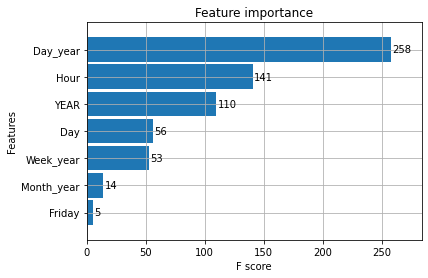

In [0]:
plot_importance(reg, height=0.9)

In [0]:
df_predicted=reg.predict(df_splited['AEP']['x_test'])

No handles with labels found to put in legend.


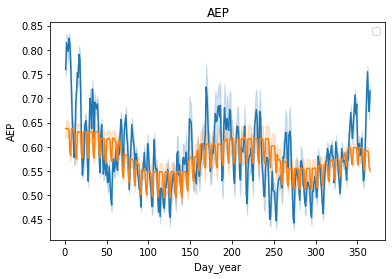

In [0]:
sns.lineplot(x=df_splited['AEP']['x_test']['Day_year'], y=df_splited['AEP']['y_test']).set_title('AEP')
sns.lineplot(x=df_splited['AEP']['x_test']['Day_year'], y=df_predicted).set_title('AEP')
f.tight_layout()
plt.legend();
#df_splited['AEP']['total'].head()

In [0]:
reg = {}
df_predicted = {}
for key in df_splited:
  reg[key] = xgb.XGBRegressor(n_estimators=1000)
  reg[key].fit(df_splited[key]['x_train'], df_splited[key]['y_train'],
          eval_set=[(df_splited[key]['x_train'], df_splited[key]['y_train']), (df_splited[key]['x_test'], df_splited[key]['y_test'])],
          early_stopping_rounds=50,
          verbose=False)
  df_predicted[key]=reg[key].predict(df_splited[key]['x_test'])

[17:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No handles with labels found to put in legend.


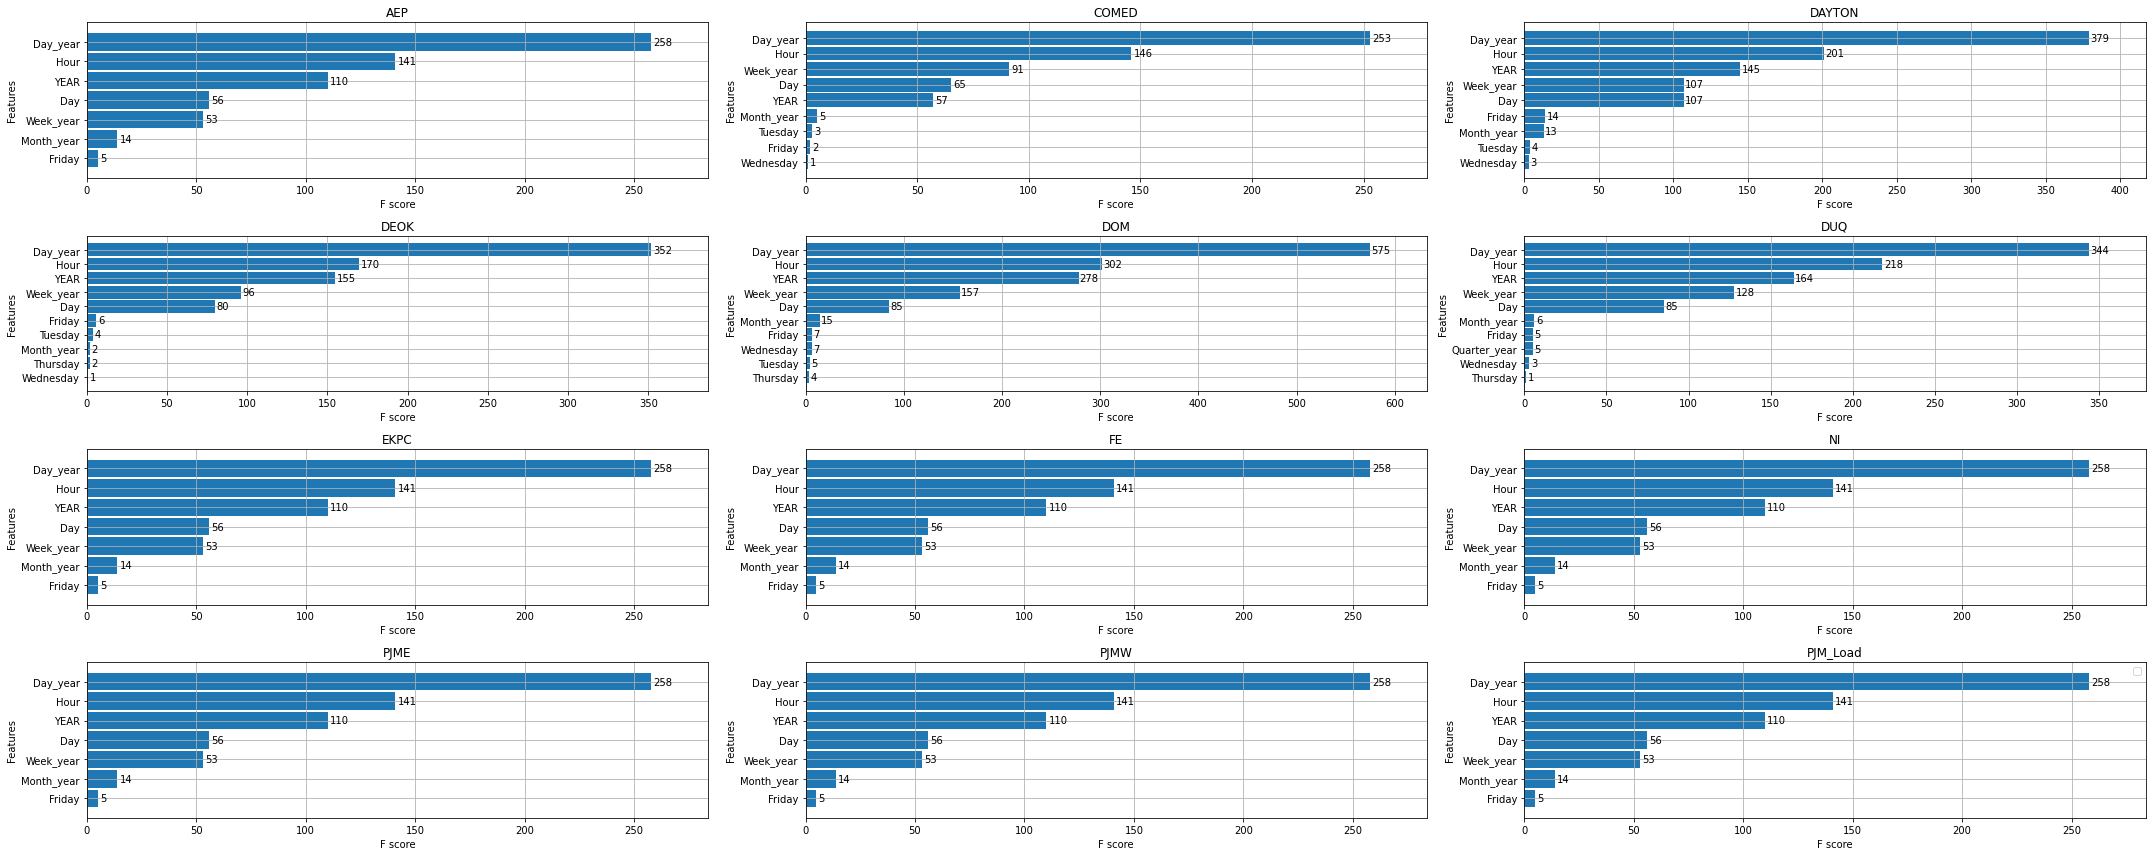

In [0]:
f, axes = plt.subplots(4, 3, figsize=(30, 12))
plot_importance(reg['AEP'], height=0.9, ax=axes[0, 0]).set_title('AEP')
plot_importance(reg['COMED'], height=0.9, ax=axes[0, 1]).set_title('COMED')
plot_importance(reg['DAYTON'], height=0.9, ax=axes[0, 2]).set_title('DAYTON')
plot_importance(reg['DEOK'], height=0.9, ax=axes[1, 0]).set_title('DEOK')
plot_importance(reg['DOM'], height=0.9, ax=axes[1, 1]).set_title('DOM')
plot_importance(reg['DUQ'], height=0.9, ax=axes[1, 2]).set_title('DUQ')
plot_importance(reg['AEP'], height=0.9, ax=axes[2, 0]).set_title('EKPC')
plot_importance(reg['AEP'], height=0.9, ax=axes[2, 1]).set_title('FE')
plot_importance(reg['AEP'], height=0.9, ax=axes[2, 2]).set_title('NI')
plot_importance(reg['AEP'], height=0.9, ax=axes[3, 0]).set_title('PJME')
plot_importance(reg['AEP'], height=0.9, ax=axes[3, 1]).set_title('PJMW')
plot_importance(reg['AEP'], height=0.9, ax=axes[3, 2]).set_title('PJM_Load')

f.tight_layout()
plt.legend();

No handles with labels found to put in legend.


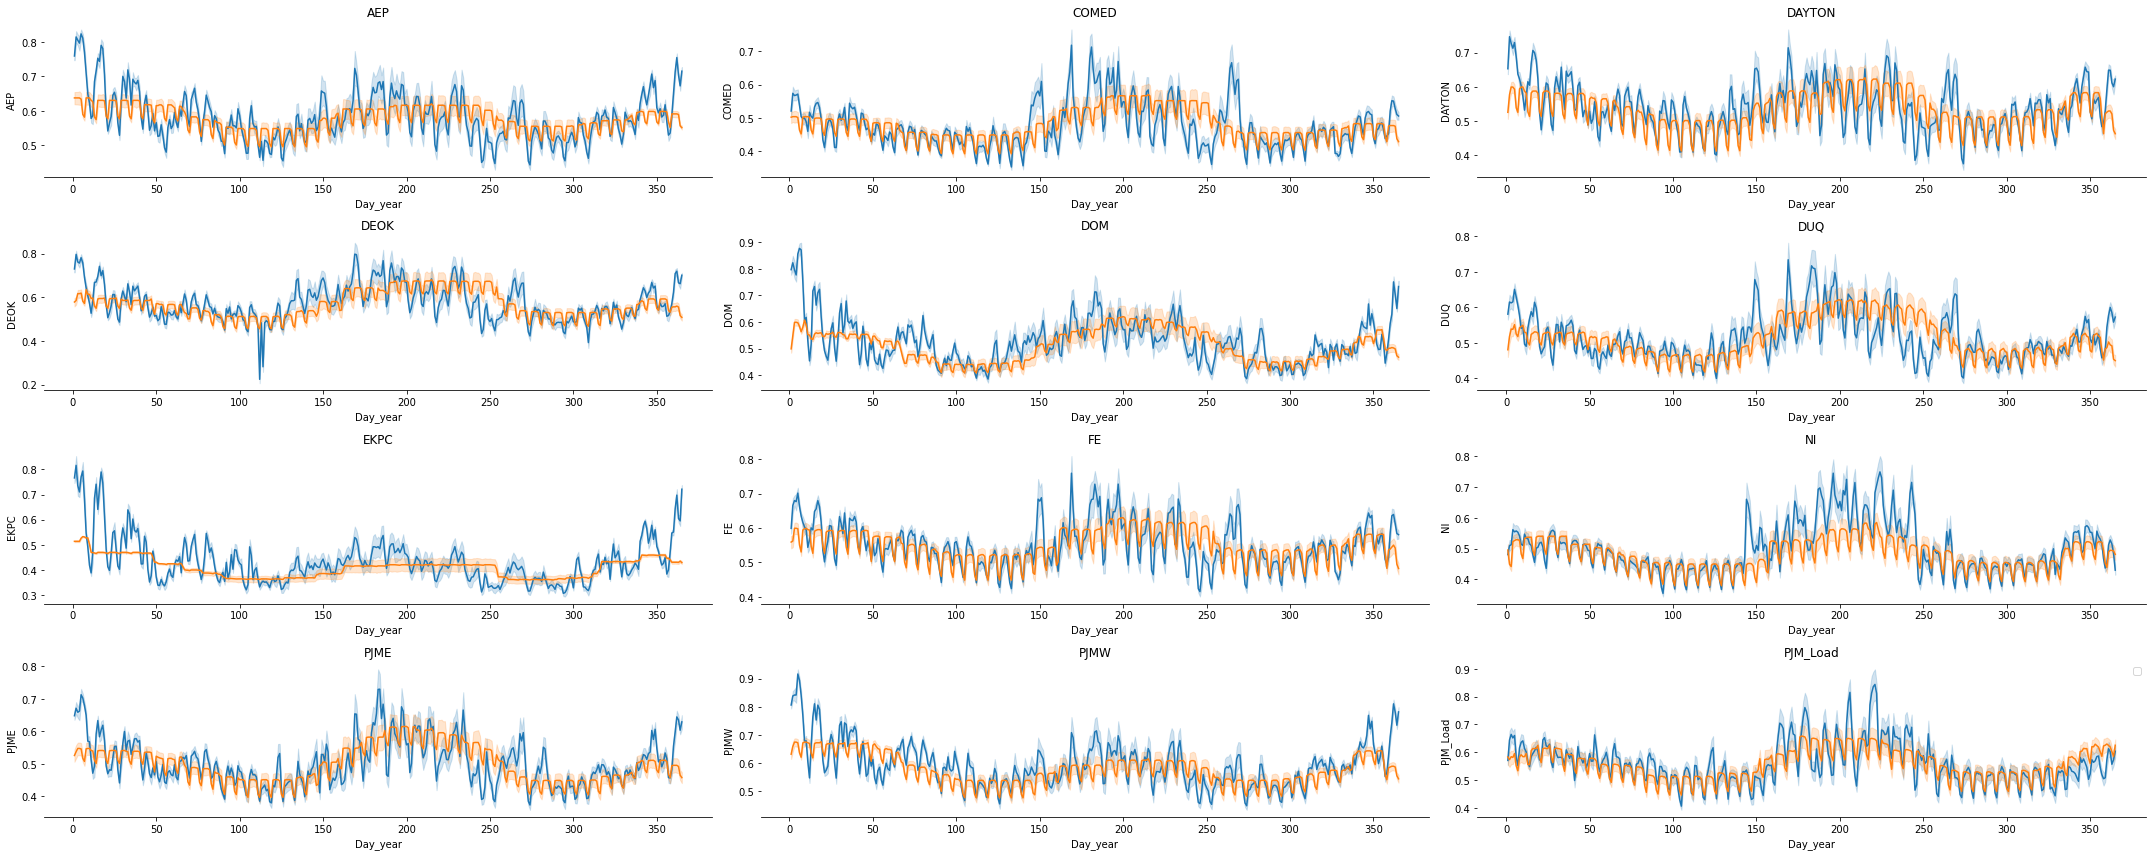

In [0]:
# gráfica de predicción vs real
f, axes = plt.subplots(4, 3, figsize=(30, 12))
sns.despine(left=True)

sns.lineplot(x=df_splited['AEP']['x_test']['Day_year'], y=df_splited['AEP']['y_test'], ax=axes[0, 0]).set_title('AEP')
sns.lineplot(x=df_splited['AEP']['x_test']['Day_year'], y=df_predicted['AEP'], ax=axes[0, 0]).set_title('AEP')

sns.lineplot(x=df_splited['COMED']['x_test']['Day_year'], y=df_splited['COMED']['y_test'], ax=axes[0, 1]).set_title('COMED')
sns.lineplot(x=df_splited['COMED']['x_test']['Day_year'], y=df_predicted['COMED'], ax=axes[0, 1]).set_title('COMED')

sns.lineplot(x=df_splited['DAYTON']['x_test']['Day_year'], y=df_splited['DAYTON']['y_test'], ax=axes[0, 2]).set_title('DAYTON')
sns.lineplot(x=df_splited['DAYTON']['x_test']['Day_year'], y=df_predicted['DAYTON'], ax=axes[0, 2]).set_title('DAYTON')

sns.lineplot(x=df_splited['DEOK']['x_test']['Day_year'], y=df_splited['DEOK']['y_test'], ax=axes[1, 0]).set_title('DEOK')
sns.lineplot(x=df_splited['DEOK']['x_test']['Day_year'], y=df_predicted['DEOK'], ax=axes[1, 0]).set_title('DEOK')

sns.lineplot(x=df_splited['DOM']['x_test']['Day_year'], y=df_splited['DOM']['y_test'], ax=axes[1, 1]).set_title('DOM')
sns.lineplot(x=df_splited['DOM']['x_test']['Day_year'], y=df_predicted['DOM'], ax=axes[1, 1]).set_title('DOM')

sns.lineplot(x=df_splited['DUQ']['x_test']['Day_year'], y=df_splited['DUQ']['y_test'], ax=axes[1, 2]).set_title('DUQ')
sns.lineplot(x=df_splited['DUQ']['x_test']['Day_year'], y=df_predicted['DUQ'], ax=axes[1, 2]).set_title('DUQ')

sns.lineplot(x=df_splited['EKPC']['x_test']['Day_year'], y=df_splited['EKPC']['y_test'], ax=axes[2, 0]).set_title('EKPC')
sns.lineplot(x=df_splited['EKPC']['x_test']['Day_year'], y=df_predicted['EKPC'], ax=axes[2, 0]).set_title('EKPC')

sns.lineplot(x=df_splited['FE']['x_test']['Day_year'], y=df_splited['FE']['y_test'], ax=axes[2, 1]).set_title('FE')
sns.lineplot(x=df_splited['FE']['x_test']['Day_year'], y=df_predicted['FE'], ax=axes[2, 1]).set_title('FE')

sns.lineplot(x=df_splited['NI']['x_test']['Day_year'], y=df_splited['NI']['y_test'], ax=axes[2, 2]).set_title('NI')
sns.lineplot(x=df_splited['NI']['x_test']['Day_year'], y=df_predicted['NI'], ax=axes[2, 2]).set_title('NI')

sns.lineplot(x=df_splited['PJME']['x_test']['Day_year'], y=df_splited['PJME']['y_test'], ax=axes[3, 0]).set_title('PJME')
sns.lineplot(x=df_splited['PJME']['x_test']['Day_year'], y=df_predicted['PJME'], ax=axes[3, 0]).set_title('PJME')

sns.lineplot(x=df_splited['PJMW']['x_test']['Day_year'], y=df_splited['PJMW']['y_test'], ax=axes[3, 1]).set_title('PJMW')
sns.lineplot(x=df_splited['PJMW']['x_test']['Day_year'], y=df_predicted['PJMW'], ax=axes[3, 1]).set_title('PJMW')

sns.lineplot(x=df_splited['PJM_Load']['x_test']['Day_year'], y=df_splited['PJM_Load']['y_test'], ax=axes[3, 2]).set_title('PJM_Load')
sns.lineplot(x=df_splited['PJM_Load']['x_test']['Day_year'], y=df_predicted['PJM_Load'], ax=axes[3, 2]).set_title('PJM_Load')

f.tight_layout()
plt.legend();

## 8 Tendencias horarias, por días, por vacaciones, por largas temporadas de tiempo.

## 9 Tendencias en función de las estaciones del año.

## 10 PySpark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.uvigo.es/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
#!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"